# Notebook steps

1. Fit generative model on validation data
Fit Generative pixel model MNIST on MNIST validation data (exact beta bernoulli model)
2. Assess surprisal of model samples and data samples under this generative view 
Assess surprisal of model samples and data samples under this generative view (conditionally and unconditionally), leading to three surprisal statistics:
    1. Conditional statistic on conditional samples: `conditional_conditional`
    2. Unconditional statistic on conditional samples: `unconditional_conditional`
    3. Unconditional statistic on unconditional samples: `unconditional_unconditional`
3. Fit DP Mixture of truncated normals on surprisal values model groups and data group
4. Assess three different divergence measures to assess the difference between model group surprisal values and data group surprisal values
    1. KL between component assignments under DP Mixture
    2. KL between estimated densities under DP Mixture
    3. Wasserstein distance between surprisal histograms (no DP used)

# Imports

In [1]:
import sys
CODE_DIR = "/home/cbarkhof/fall-2021"
sys.path.append(CODE_DIR)

In [2]:
import os
import torch
import numpy as np
import pandas as pd

%config InlineBackend.figure_format='retina'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import seaborn as sns; sns.set()

from analysis.bda_models.bda_dp_mixture_surprisal_vals import *
from analysis.bda_models.bda_pixel_model_mnist import GenPixelModelMNIST
from analysis_run_postprocessing.general_postprocessing_steps import make_run_overview_df

from dataset_dataloader import get_n_data_samples_x_y

# Get some MNIST data

In [3]:
N_DATA_SAMPLES = 1000

train_x, train_y = get_n_data_samples_x_y(image_dataset_name="bmnist", image_or_language="image", 
                                          N_samples=N_DATA_SAMPLES, phase="train")
valid_x, valid_y = get_n_data_samples_x_y(image_dataset_name="bmnist", image_or_language="image", 
                                          N_samples=N_DATA_SAMPLES, phase="valid")

VALID_OBS_X = valid_x.flatten(start_dim=1).numpy()
VALID_OBS_Y = valid_y.long().numpy()

TRAIN_OBS_X = train_x.flatten(start_dim=1).numpy()
TRAIN_OBS_Y = train_y.long().numpy()

# Generative Pixel Model MNIST (train & validation)

The generative model is a DP Mixture beta bernoulli model with 10 components (for the 10 digits).

In [4]:
NUM_SAMPLES = 1000

# No need to pass chains and warmup because it is an exact model
gen_model = GenPixelModelMNIST(
    obs_x=TRAIN_OBS_X, 
    obs_y=TRAIN_OBS_Y, 
    num_samples=NUM_SAMPLES, 
)

I0114 10:44:12.654603 23185976098560 tpu_client.py:54] Starting the local TPU driver.
I0114 10:44:12.657248 23185976098560 xla_bridge.py:231] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
I0114 10:44:12.658407 23185976098560 xla_bridge.py:231] Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
I0114 10:44:12.659236 23185976098560 xla_bridge.py:231] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


# Gather models to evaluate under the fit generative model

In [5]:
prefixes = ["(mdr-vae-exp 8 oct)", "(fb-vae-exp 8 oct) ", "(beta-vae-exp 6 oct) ", "(inf-vae-exp 5 oct) "]
run_df = make_run_overview_df(prefixes=prefixes)
run_df

objective l_rate dataset  \
MDR-VAE 40 dec: CNN.T                            MDR-VAE      0  bmnist   
MDR-VAE 32 dec: CNN.T                            MDR-VAE      0  bmnist   
MDR-VAE 24 dec: CNN.T                            MDR-VAE      0  bmnist   
MDR-VAE 16 dec: CNN.T                            MDR-VAE      0  bmnist   
MDR-VAE 8 dec: CNN.T                             MDR-VAE      0  bmnist   
...                                                  ...    ...     ...   
INFO-VAE l_Rate 100 l_MMD 100 dec: CNN.T        INFO-VAE    100  bmnist   
INFO-VAE l_Rate 1000 l_MMD 1 dec: CNN.T         INFO-VAE   1000  bmnist   
INFO-VAE l_Rate 100 l_MMD 1000 dec: PixelCNN++  INFO-VAE    100  bmnist   
INFO-VAE l_Rate 1 l_MMD 1000 dec: CNN.T         INFO-VAE      1  bmnist   
INFO-VAE l_Rate 1000 l_MMD 100 dec: PixelCNN++  INFO-VAE   1000  bmnist   

                                               image_or_language beta_beta  \
MDR-VAE 40 dec: CNN.T                                      image         0   
MDR-VAE 32 dec: CNN.T                                      image         0   
MDR-VAE 24 dec: CNN.T                                      image         0   
MDR-VAE 16 dec: CNN.T                                      image         0   
MDR-VAE 8 dec: CNN.T                                       image         0   
...                                                          ...       ...   
INFO-VAE l_Rate 100 l_MMD 100 dec: CNN.T                   image         0   
INFO-VAE l_Rate 1000 l_MMD 1 dec: CNN.T                    image         0   
INFO-VAE l_Rate 100 l_MMD 1000 dec: PixelCNN++             image         0   
INFO-VAE l_Rate 1 l_MMD 1000 dec: CNN.T                    image         0   
INFO-VAE l_Rate 1000 l_MMD 100 dec: PixelCNN++             image         0   

                                               free_bits mdr_value l_mmd  \
MDR-VAE 40 dec: CNN.T                                  0        40     0   
MDR-VAE 32 dec: CNN.T                                  0        32     0   
MDR-VAE 24 dec: CNN.T                                  0        24     0   
MDR-VAE 16 dec: CNN.T                                  0        16     0   
MDR-VAE 8 dec: CNN.T                                   0         8     0   
...                                                  ...       ...   ...   
INFO-VAE l_Rate 100 l_MMD 100 dec: CNN.T               0         0   100   
INFO-VAE l_Rate 1000 l_MMD 1 dec: CNN.T                0         0     1   
INFO-VAE l_Rate 100 l_MMD 1000 dec: PixelCNN++         0         0  1000   
INFO-VAE l_Rate 1 l_MMD 1000 dec: CNN.T                0         0  1000   
INFO-VAE l_Rate 1000 l_MMD 100 dec: PixelCNN++         0         0   100   

                                                             decoder  \
MDR-VAE 40 dec: CNN.T                           basic_deconv_decoder   
MDR-VAE 32 dec: CNN.T                           basic_deconv_decoder   
MDR-VAE 24 dec: CNN.T                           basic_deconv_decoder   
MDR-VAE 16 dec: CNN.T                           basic_deconv_decoder   
MDR-VAE 8 dec: CNN.T                            basic_deconv_decoder   
...                                                              ...   
INFO-VAE l_Rate 100 l_MMD 100 dec: CNN.T        basic_deconv_decoder   
INFO-VAE l_Rate 1000 l_MMD 1 dec: CNN.T         basic_deconv_decoder   
INFO-VAE l_Rate 100 l_MMD 1000 dec: PixelCNN++     cond_pixel_cnn_pp   
INFO-VAE l_Rate 1 l_MMD 1000 dec: CNN.T         basic_deconv_decoder   
INFO-VAE l_Rate 1000 l_MMD 100 dec: PixelCNN++     cond_pixel_cnn_pp   

                                                                                         run_name  
MDR-VAE 40 dec: CNN.T                           (mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...  
MDR-VAE 32 dec: CNN.T                           (mdr-vae-exp 8 oct) MDR-VAE[R>=32.0] | q(z|x) ...  
MDR-VAE 24 dec: CNN.T                           (mdr-vae-exp 8 oct) MDR-VAE[R>=24.0] | q(z|x) ...  
MDR-VAE 16 dec: CNN.T          

# Gather samples from disk

In [6]:
EXPORT_DIR = f"{CODE_DIR}/analysis_run_postprocessing/run_postprocess_files"
SAMPLE_FILE = f"generative-samples.pt"
CONDITIONAL_SAMPLE_FILE = f"generative-conditional-samples.pt"

MAX_SAMPLES_PER_MODEL = 500 # 500 is currently its max

model_samples = dict()

for idx, run_name in enumerate(os.listdir(EXPORT_DIR)):
    if run_name in run_df.run_name.values:
        
        clean_name = run_df[run_df.run_name == run_name].index.values[0]
        
        save_dir = f"{EXPORT_DIR}/{run_name}"
        
        # Dict with keys conditional_x, conditional_y
        conditional_samples = torch.load(f"{save_dir}/{CONDITIONAL_SAMPLE_FILE}")["valid"]
        unconditional_samples = torch.load(f"{save_dir}/{SAMPLE_FILE}")
        
        conditional_x = conditional_samples["cond_sample_x"]
        condition_y = conditional_samples["original_y"]
        unconditional_x = unconditional_samples["x"]
        
        if len(conditional_x) < MAX_SAMPLES_PER_MODEL:
            print(f"not enough conditional_x samples {len(conditional_x)} < {MAX_SAMPLES_PER_MODEL}")
            
        if len(unconditional_x) < MAX_SAMPLES_PER_MODEL:
            print(f"not enough unconditional_x samples {len(unconditional_x)} < {MAX_SAMPLES_PER_MODEL}")
        
        model_samples[clean_name] = dict(
            unconditional_x=unconditional_x[:MAX_SAMPLES_PER_MODEL].reshape(-1, 28*28).numpy(),
            conditional_x=conditional_x[:MAX_SAMPLES_PER_MODEL].reshape(-1, 28*28).numpy(),
            condition_y=condition_y[:MAX_SAMPLES_PER_MODEL].long().numpy()
        )
        
        print(idx, clean_name)
        print("unconditional_x", model_samples[clean_name]["unconditional_x"].shape)
        print("conditional_x", model_samples[clean_name]["conditional_x"].shape)
        print("condition_y", model_samples[clean_name]["condition_y"].shape, end='\n\n')
        
model_samples["data_group"] = dict(
    unconditional_x=VALID_OBS_X,
    conditional_x=VALID_OBS_X,
    condition_y=VALID_OBS_Y)


18 MDR-VAE 40 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

19 MDR-VAE 32 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

20 MDR-VAE 24 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

21 MDR-VAE 16 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

22 MDR-VAE 8 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

23 MDR-VAE 4 dec: CNN.T
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

24 MDR-VAE 40 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

25 MDR-VAE 32 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

26 MDR-VAE 24 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

27 MDR-VAE 16 dec: PixelCNN++
unconditional_x (500, 784)
conditional_x (500, 784)
condition_y (500,)

28 MDR-VAE 8

# Assess the fit of the generative model

## Collect & plot some posterior predictive samples

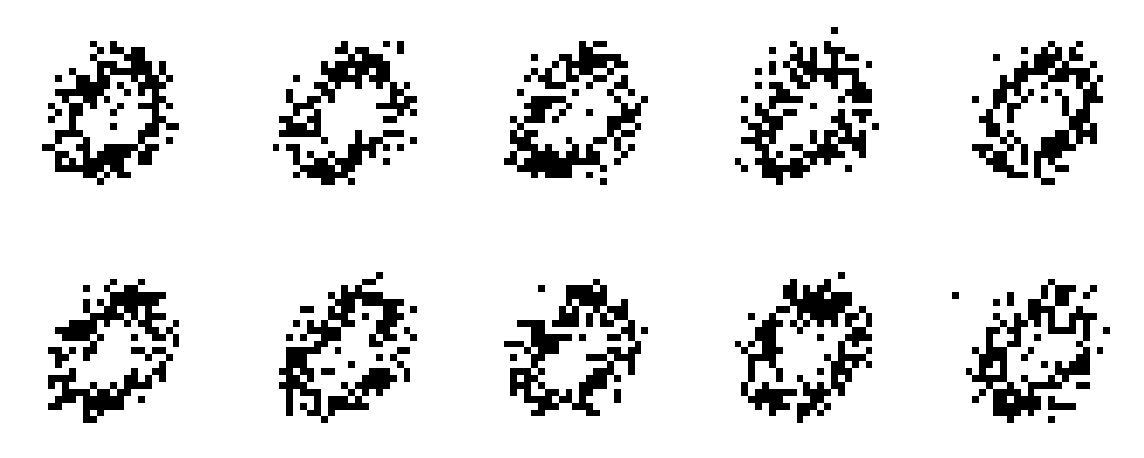

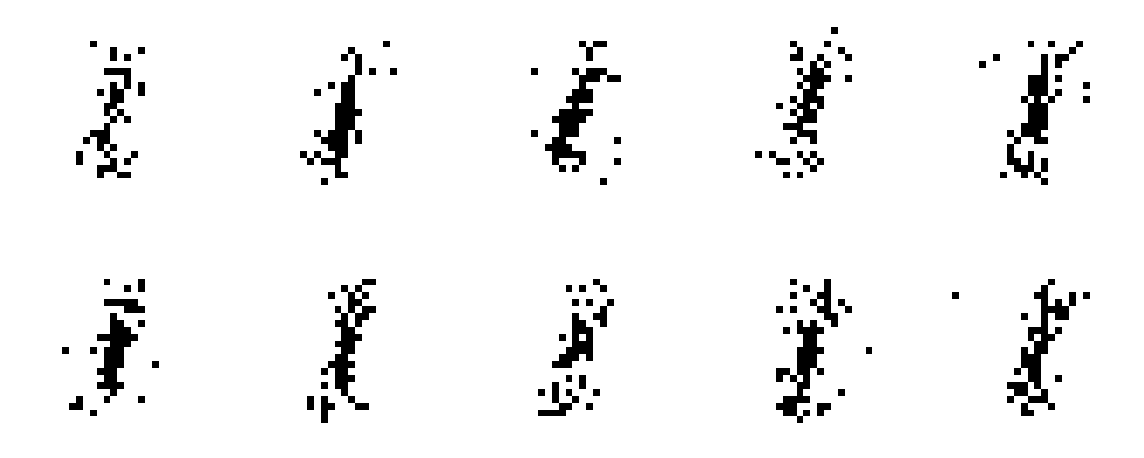

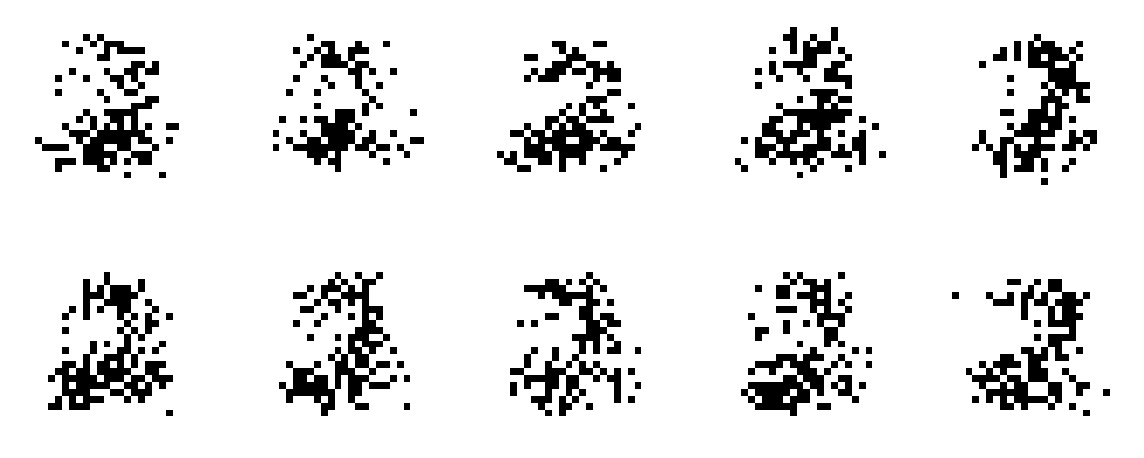

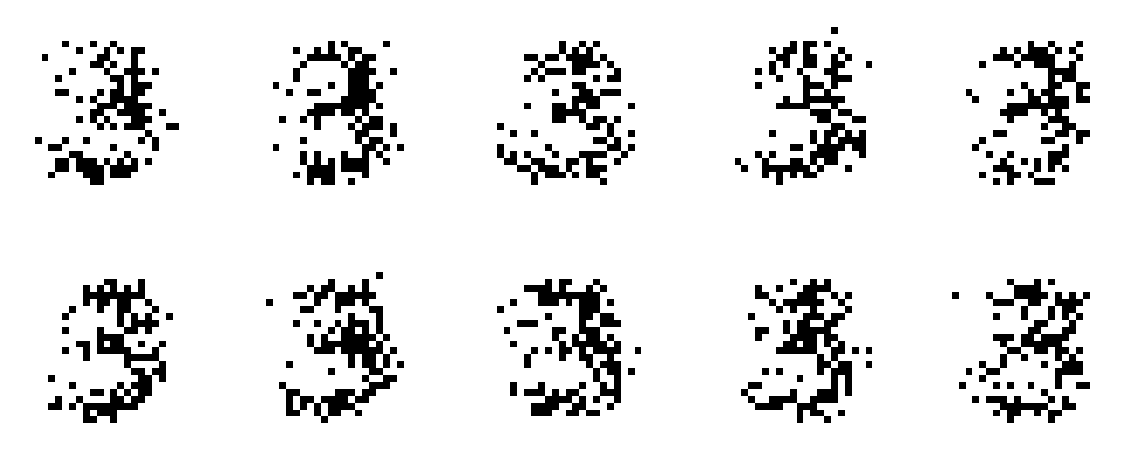

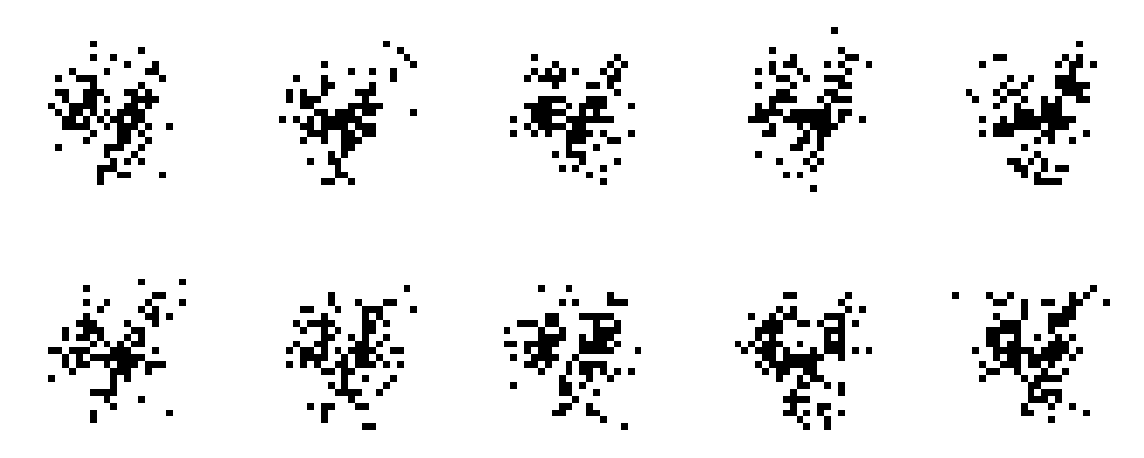

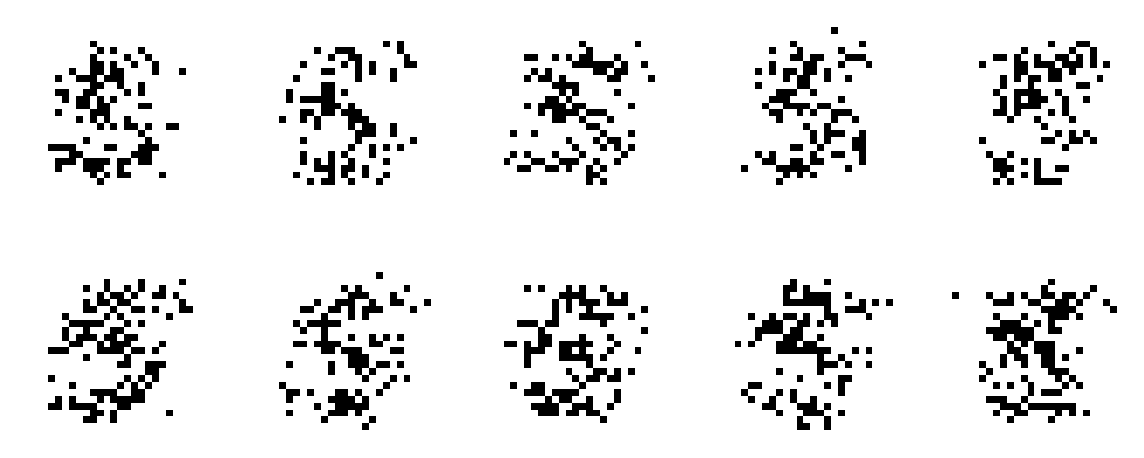

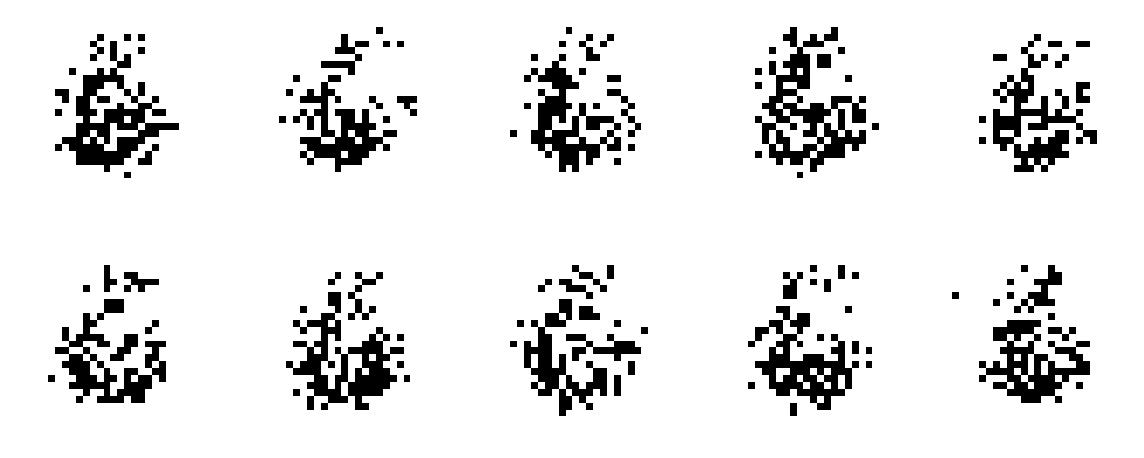

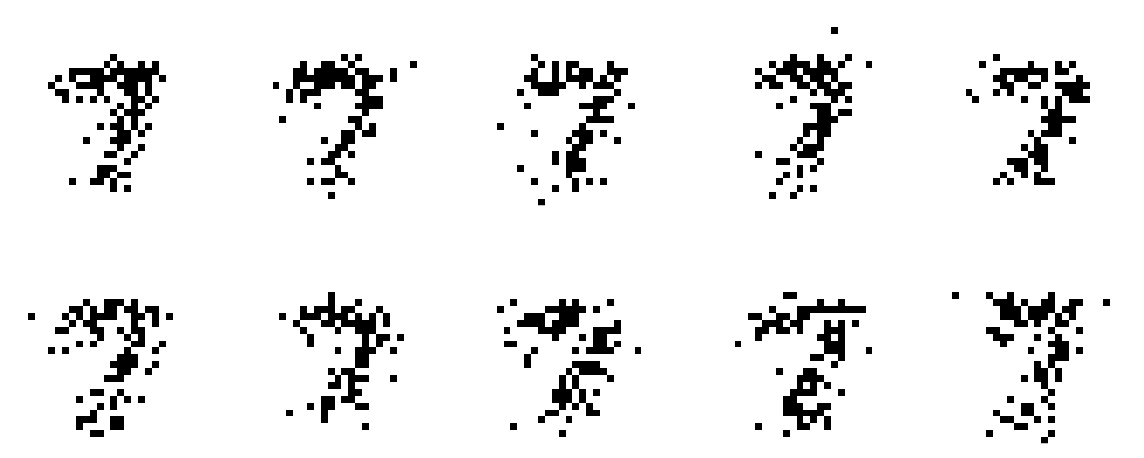

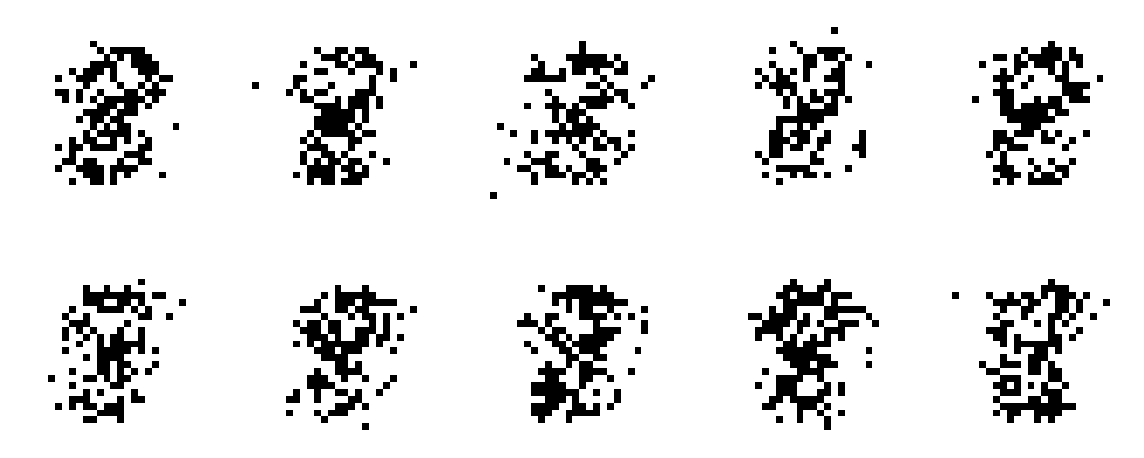

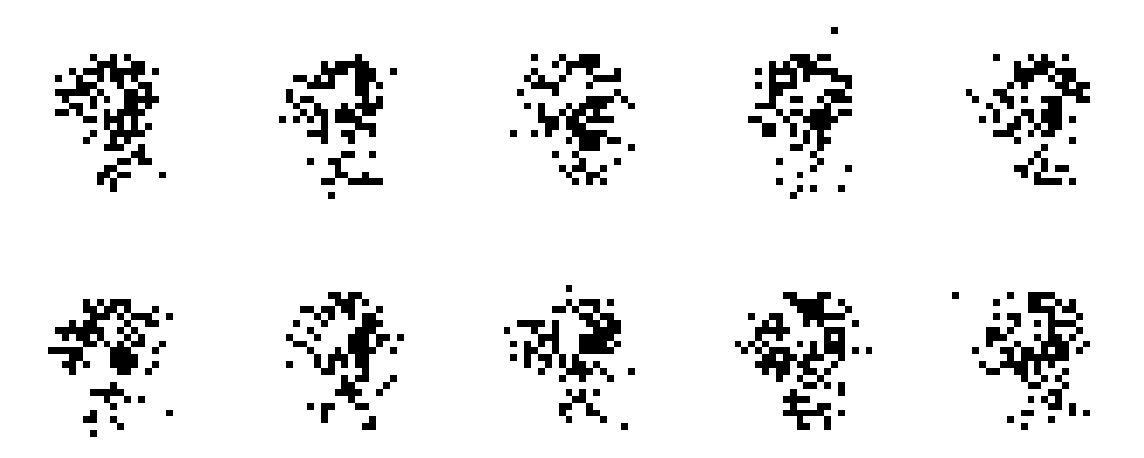

In [8]:
ncols = 5
nrows = 2
nplots = nrows * ncols

for digit in range(10):
    obs_ys = np.ones(nplots).astype(int) * digit
    rng_key, rng_key_ = random.split(gen_model.rng_key)
    cond_posterior_pred = gen_model.conditional_posterior_predictive(obs_ys=obs_ys).sample(key=rng_key_)
    
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows))

    for i in range(nplots): 
        c = i % ncols
        r = i // ncols
        ax[r, c].imshow(np.array(cond_posterior_pred[i].reshape(28, 28)), cmap="Greys")
        ax[r, c].grid("off")
        ax[r, c].set_xticks([])
        ax[r, c].set_yticks([])
    
    plt.show()

# Sample from conditional posterior predictive

In [11]:
npost_samples = 100
samples = dict()

for digit in range(10):
    print(f"{digit:2d}/10", end="\r")
    valid_y_digit = VALID_OBS_Y[VALID_OBS_Y == digit]
    rng_key, rng_key_ = random.split(gen_model.rng_key)
    
    # N_post_samples, N_data, 784
    cond_posterior_pred = gen_model.conditional_posterior_predictive(obs_ys=valid_y_digit).sample(
        key=rng_key_, sample_shape=(npost_samples,))
    
    samples[digit] = cond_posterior_pred

# Plot true versus sampled digit

In [ ]:
fig, ax = plt.subplots(ncols=3, nrows=10, figsize=(3*3, 3*10))

for k in range(10):
    # 2D [N, 786]
    true_digits = VALID_OBS_X[VALID_OBS_Y == k]
    avg_true_digit = true_digits.mean(axis=0)
    
    # 3D [S, N, 786]
    sampeld_digits = samples[k]
    avg_sampled_digit = sampeld_digits.mean(axis=0).mean(axis=0)
    
    ax[k, 0].imshow(avg_true_digit.reshape(28, 28), cmap="Greys")
    ax[k, 0].set_title(f"Avg. true digit {k}")
    ax[k, 1].imshow(avg_sampled_digit.reshape(28, 28), cmap="Greys")
    ax[k, 1].set_title(f"Avg. sampled digit {k}")
    ax[k, 2].imshow(np.abs(avg_true_digit-avg_sampled_digit).reshape(28, 28), cmap="Greys")
    ax[k, 2].set_title(f"Abs dif. between\navg. true and sampled digit {k}")
    
    for i in range(3):
        ax[k, i].grid("off")
        ax[k, i].set_xticks([])
        ax[k, i].set_yticks([])
    

# Posterior predictive checks

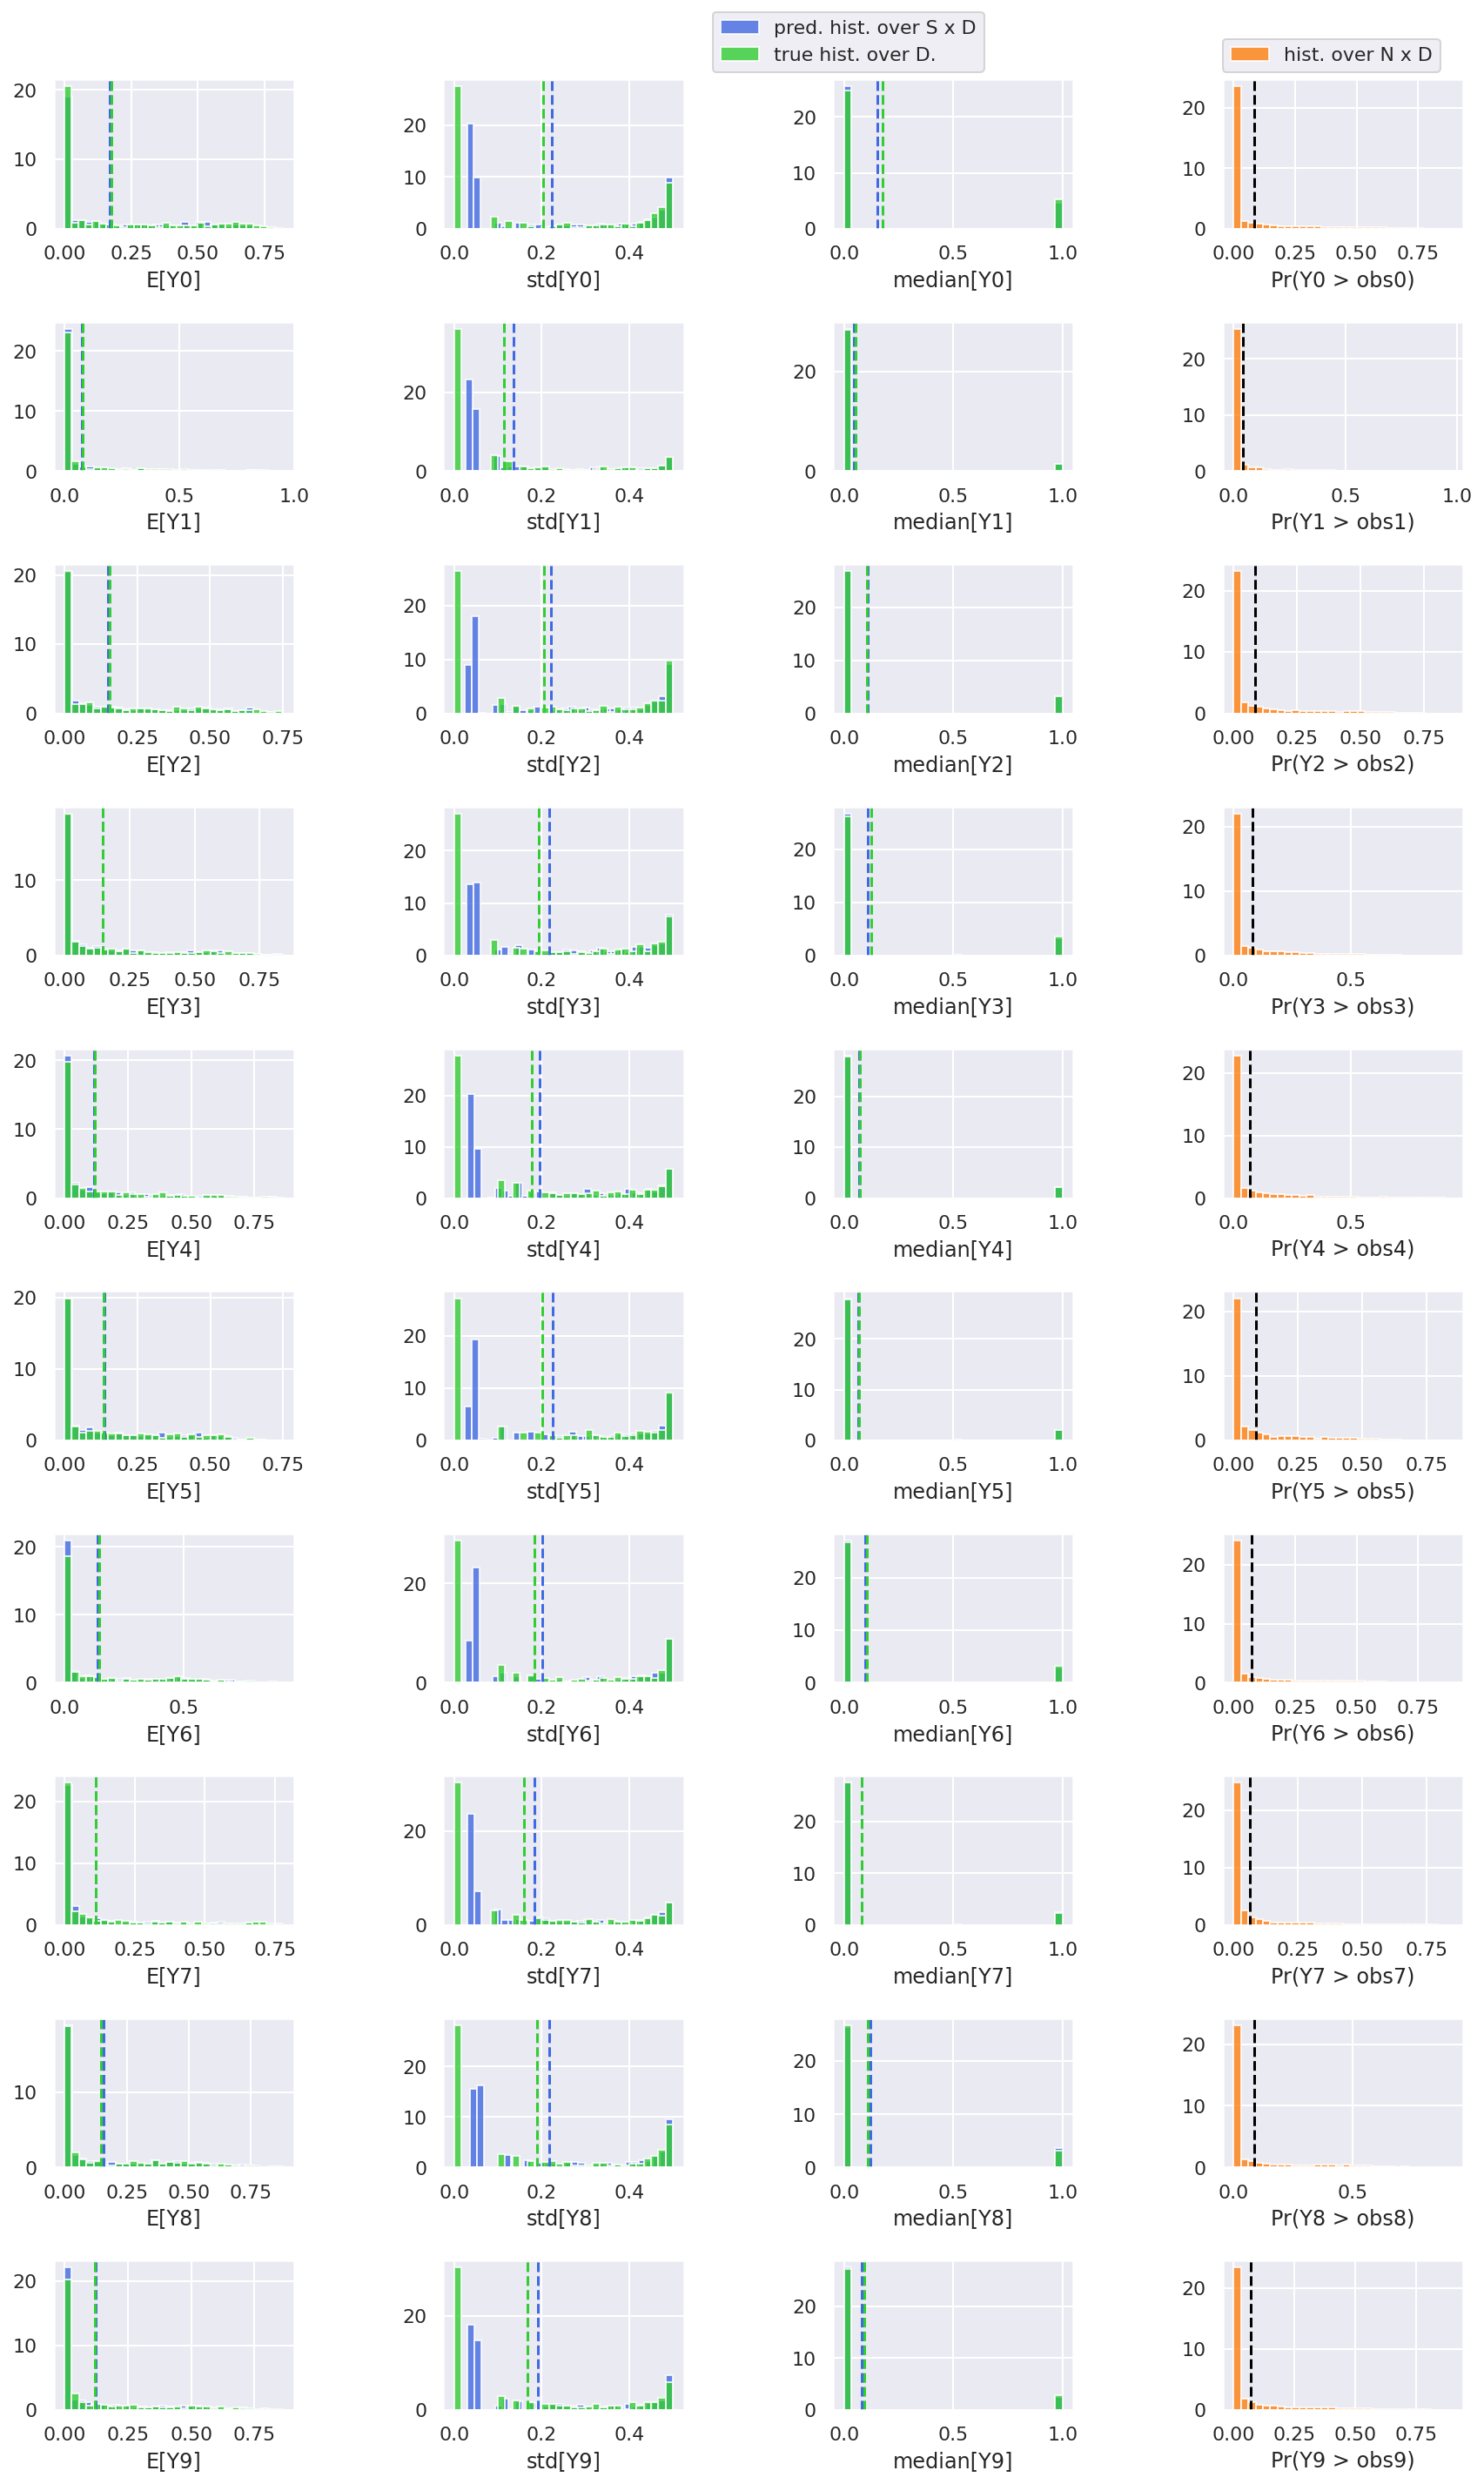

In [54]:
fig, ax = plt.subplots(ncols=4, nrows=10, figsize=(3*4, 2*10))

hist_kwargs = dict(bins=30, density=True, alpha=0.8)
line_kwargs = dict(linestyle='--')

for k in range(10):
    print(f"{k:2d}/10", end="\r")
    
    # 2D [N, 786]
    true_digits = VALID_OBS_X[VALID_OBS_Y == k]
    
    # 3D [S, N, 786]
    sampled_digits = samples[k]
    sampled_digits_2d = sampled_digits.reshape(-1, 28*28)
    
    # Hist of pixel means (hist over all pixels)
    ax[k, 0].hist(sampled_digits_2d.mean(axis=0), **hist_kwargs, color="royalblue", label="pred. hist. over S x D")
    ax[k, 0].hist(true_digits.mean(axis=0), **hist_kwargs, color="limegreen", label="true hist. over D.")
    ax[k, 0].axvline(np.mean(sampled_digits_2d.mean(axis=0)), **line_kwargs, color="royalblue")
    ax[k, 0].axvline(np.mean(true_digits.mean(axis=0)), **line_kwargs, color="limegreen")
    ax[k, 0].set_xlabel(f'E[Y{k}]')
    
    # Hist of pixel std (hist over all pixels)
    ax[k, 1].hist(sampled_digits_2d.std(axis=0), **hist_kwargs, color="royalblue", label="pred. hist. over S x D")
    ax[k, 1].hist(true_digits.std(axis=0), **hist_kwargs, color="limegreen", label="true hist. over D.")
    ax[k, 1].axvline(np.mean(sampled_digits_2d.std(axis=0)), **line_kwargs, color="royalblue")
    ax[k, 1].axvline(np.mean(true_digits.std(axis=0)), **line_kwargs, color="limegreen")
    ax[k, 1].set_xlabel(f'std[Y{k}]')
    
    # Hist of pixel std (hist over all pixels)
    ax[k, 2].hist(np.median(sampled_digits_2d, axis=0), **hist_kwargs, color="royalblue", label="pred. hist. over S x D")
    ax[k, 2].hist(np.median(true_digits, axis=0), **hist_kwargs, color="limegreen", label="true hist. over D.")
    ax[k, 2].axvline(np.mean(np.median(sampled_digits_2d, axis=0)), **line_kwargs, color="royalblue")
    ax[k, 2].axvline(np.mean(np.median(true_digits, axis=0)), **line_kwargs, color="limegreen")
    ax[k, 2].set_xlabel(f'median[Y{k}]')
    
    if k == 0:
        ax[k, 2].legend(loc=(-0.5, 1.05))
    
    true_digits_unsqueeze = true_digits[None, :, :]
    
    # true_digits_unsqueeze: [1, N, D]
    # sampled_digits: [S, N, D]
    # pvals: [N, D]
    pvals = (sampled_digits > true_digits_unsqueeze).mean(axis=0)
    pvals = pvals.flatten()
    
    pvals_avg = pvals.mean()
    ax[k, 3].hist(pvals, **hist_kwargs, color="tab:orange", label="hist. over N x D")
    ax[k, 3].axvline(pvals_avg, **line_kwargs, color="black")
    ax[k, 3].set_xlabel(f'Pr(Y{k} > obs{k})')
    
    if k == 0:
        ax[k, 3].legend(loc=(0.0, 1.05))

plt.tight_layout()

# Assess surprisal of model samples under generative model

In [4]:
re_compute = False
save_file = "MNIST_surprisal_values.pt"

if re_compute:

    surprisal_values = dict()

    for idx, (run_name, samples) in enumerate(model_samples.items()):
        print(f"{idx:2d}/{len(model_samples.keys())}", end='\r')

        unconditional_unconditional = - gen_model.assess_unconditional_posterior_predictive(samples["unconditional_x"])
        unconditional_conditional = - gen_model.assess_unconditional_posterior_predictive(samples["conditional_x"])
        conditional_conditional = - gen_model.conditional_posterior_predictive(samples["condition_y"]).log_prob(samples["conditional_x"])

        surprisal_values[run_name] = dict(
            unconditional_unconditional=unconditional_unconditional,
            unconditional_conditional=unconditional_conditional,
            conditional_conditional=conditional_conditional
        )

    torch.save(surprisal_values, save_file)

else:
    surprisal_values = torch.load(save_file)


# Plot surprisal distribution and add global statistics

In [5]:
global_stats_df = pd.read_csv("/home/cbarkhof/fall-2021/analysis/global_stats.csv", index_col=0)
global_stats_df = global_stats_df[global_stats_df.phase == "valid"]
global_stats_df = global_stats_df[global_stats_df.index.isin(run_df.index)]
global_stats_df.head()

phase       IW LL       MMD  PPL  distortion  \
MDR-VAE 40 dec: CNN.T  valid -103.188726  0.147525  NaN   67.759498   
MDR-VAE 32 dec: CNN.T  valid  -95.989883  0.072290  NaN   67.617790   
MDR-VAE 24 dec: CNN.T  valid  -88.468610  0.017464  NaN   69.936762   
MDR-VAE 16 dec: CNN.T  valid  -88.710750  0.011984  NaN   72.589826   
MDR-VAE 8 dec: CNN.T   valid  -89.978040  0.010652  NaN   72.503336   

                             elbo  kl_prior_post  mean_mean  mean_scale  \
MDR-VAE 40 dec: CNN.T -107.277272      39.517773   0.100267    0.037576   
MDR-VAE 32 dec: CNN.T  -99.674962      32.057172  -0.057504    0.053061   
MDR-VAE 24 dec: CNN.T  -94.049765      24.113002  -0.010380    0.110114   
MDR-VAE 16 dec: CNN.T  -93.119502      20.529676  -0.009123    0.155799   
MDR-VAE 8 dec: CNN.T   -93.129631      20.626294  -0.003034    0.158074   

                       std_across_x_mean  ...  objective  l_rate  dataset  \
MDR-VAE 40 dec: CNN.T           1.416498  ...    MDR-VAE     0.0   bmnist   
MDR-VAE 32 dec: CNN.T           1.149772  ...    MDR-VAE     0.0   bmnist   
MDR-VAE 24 dec: CNN.T           1.061235  ...    MDR-VAE     0.0   bmnist   
MDR-VAE 16 dec: CNN.T           1.018218  ...    MDR-VAE     0.0   bmnist   
MDR-VAE 8 dec: CNN.T            1.028358  ...    MDR-VAE     0.0   bmnist   

                      image_or_language beta_beta  free_bits mdr_value l_mmd  \
MDR-VAE 40 dec: CNN.T             image       0.0          0        40     0   
MDR-VAE 32 dec: CNN.T             image       0.0          0        32     0   
MDR-VAE 24 dec: CNN.T             image       0.0          0        24     0   
MDR-VAE 16 dec: CNN.T             image       0.0          0        16     0   
MDR-VAE 8 dec: CNN.T              image       0.0          0         8     0   

                                    decoder  \
MDR-VAE 40 dec: CNN.T  basic_deconv_decoder   
MDR-VAE 32 dec: CNN.T  basic_deconv_decoder   
MDR-VAE 24 dec: CNN.T  basic_deconv_decoder   
MDR-VAE 16 dec: CNN.T  basic_deconv_decoder   
MDR-VAE 8 dec: CNN.T   basic_deconv_decoder   

                                                                run_name  
MDR-VAE 40 dec: CNN.T  (mdr-vae-exp 8 oct) MDR-VAE[R>=40.0] | q(z|x) ...  
MDR-VAE 32 dec: CNN.T  (mdr-vae-exp 8 oct) MDR-VAE[R>=32.0] | q(z|x) ...  
MDR-VAE 24 dec: CNN.T  (mdr-vae-exp 8 oct) MDR-VAE[R>=24.0] | q(z|x) ...  
MDR-VAE 16 dec: CNN.T  (mdr-vae-exp 8 oct) MDR-VAE[R>=16.0] | q(z|x) ...  
MDR-VAE 8 dec: CNN.T   (mdr-vae-exp 8 oct) MDR-VAE[R>=8.0] | q(z|x) i...  

[5 rows x 24 columns]

In [59]:
def plot_surprisal_dists_against_global_stat(global_stats_df, surprisal_values, sort_on, sort_name,
                                             dataset_name, latent_structure,
                                             xlims, ylims, bins=40, title_size=14, title_y=1.02,
                                             subsample_nrows=None, 
                                             sort_ascend=True, row_height=1.0):
    
    assert sort_on in global_stats_df.columns, f"{sort_on} must be in global_stats_df.columns"

    if subsample_nrows is not None:
        if len(global_stats_df) < subsample_nrows:
            print(f"Warning, subsample_nrows {subsample_nrows} < len(global_stats_df) {len(global_stats_df)}")

    model_cols = ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional']
    model_col_names = ["-log p(x*|x) unconditional samples", "-log p(x*|x) conditional samples",
                       "-log p(x*|x, y*) conditional samples"]

    ncols = len(model_cols)

    group_names = global_stats_df.index.unique()
    for g in group_names:
        assert g in surprisal_values, f"{g} not in surprisal_values dict"

    ngroups = len(group_names)

    if subsample_nrows is None:
        nrows = ngroups
        idxs = np.arange(ngroups)
    else:
        nrows = subsample_nrows
        idxs = np.round(np.linspace(0, len(np.arange(ngroups)) - 1, subsample_nrows)).astype(int)
            
    print(f"Rows: {nrows}, cols: {ncols}, n_groups: {ngroups}, len(idxs)={len(idxs)}")

    hist_kwargs = dict(lw=0, alpha=0.7, density=True, bins=bins)

    # Sort
    df_sort_on = global_stats_df.sort_values(sort_on, ascending=sort_ascend)[sort_on]
    sort_on_labels, sort_on_values = df_sort_on.index, df_sort_on.values
    labels = [f"{l} | {sort_name}={v:.2f}" for l, v in zip(sort_on_labels, sort_on_values)]

    # Make colormap based on sort values
    minima, maxima = min(sort_on_values), max(sort_on_values)
    norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

    # Fig
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols * 6, nrows * row_height))  #
    
    for col, col_name in enumerate(model_cols):
        row = 0
        for idx, group_name in enumerate(sort_on_labels):
            if idx not in idxs:
                continue

            #if group_name not in surprisal_values:
            #    continue

            color = mapper.to_rgba(sort_on_values[idx])

            axs[row, col].hist(surprisal_values["data_group"][model_cols[col]], color="grey", **hist_kwargs)
            axs[row, col].hist(surprisal_values[group_name][model_cols[col]], color=color, **hist_kwargs)

            if col == 0:
                axs[row, col].text(-0.05, .5, labels[idx], color='black', fontsize=10, ha="right", va="center",
                                   transform=axs[row, col].transAxes)

            # axs[row, col].set_yticks([])
            # axs[row, col].set_xticks([])
            if xlims[col] is not None:
                axs[row, col].set_xlim(xlims[col])
            if ylims[col] is not None:
                axs[row, col].set_ylim(ylims[col])

            # only show ticks for bottom row
            if row + 1 < nrows:
                axs[row, col].axes.xaxis.set_ticklabels([])

            axs[row, col].axes.yaxis.set_ticklabels([])

            if row == 0:
                axs[row, col].set_title(model_col_names[col])

            row += 1

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    if subsample_nrows is not None:
        plt.suptitle(
            f"{dataset_name} | {latent_structure} | - log p(x) plots, coloured by {sort_name}\nsubsampled {subsample_nrows}/{ngroups} spread over {sort_name} order",
            y=title_y, size=title_size)
    else:
        plt.suptitle(f"{dataset_name} | {latent_structure} | - log p(x) plots, coloured by {sort_name}", y=title_y,
                     size=title_size)

Rows: 30, cols: 3, n_groups: 50, len(idxs)=30


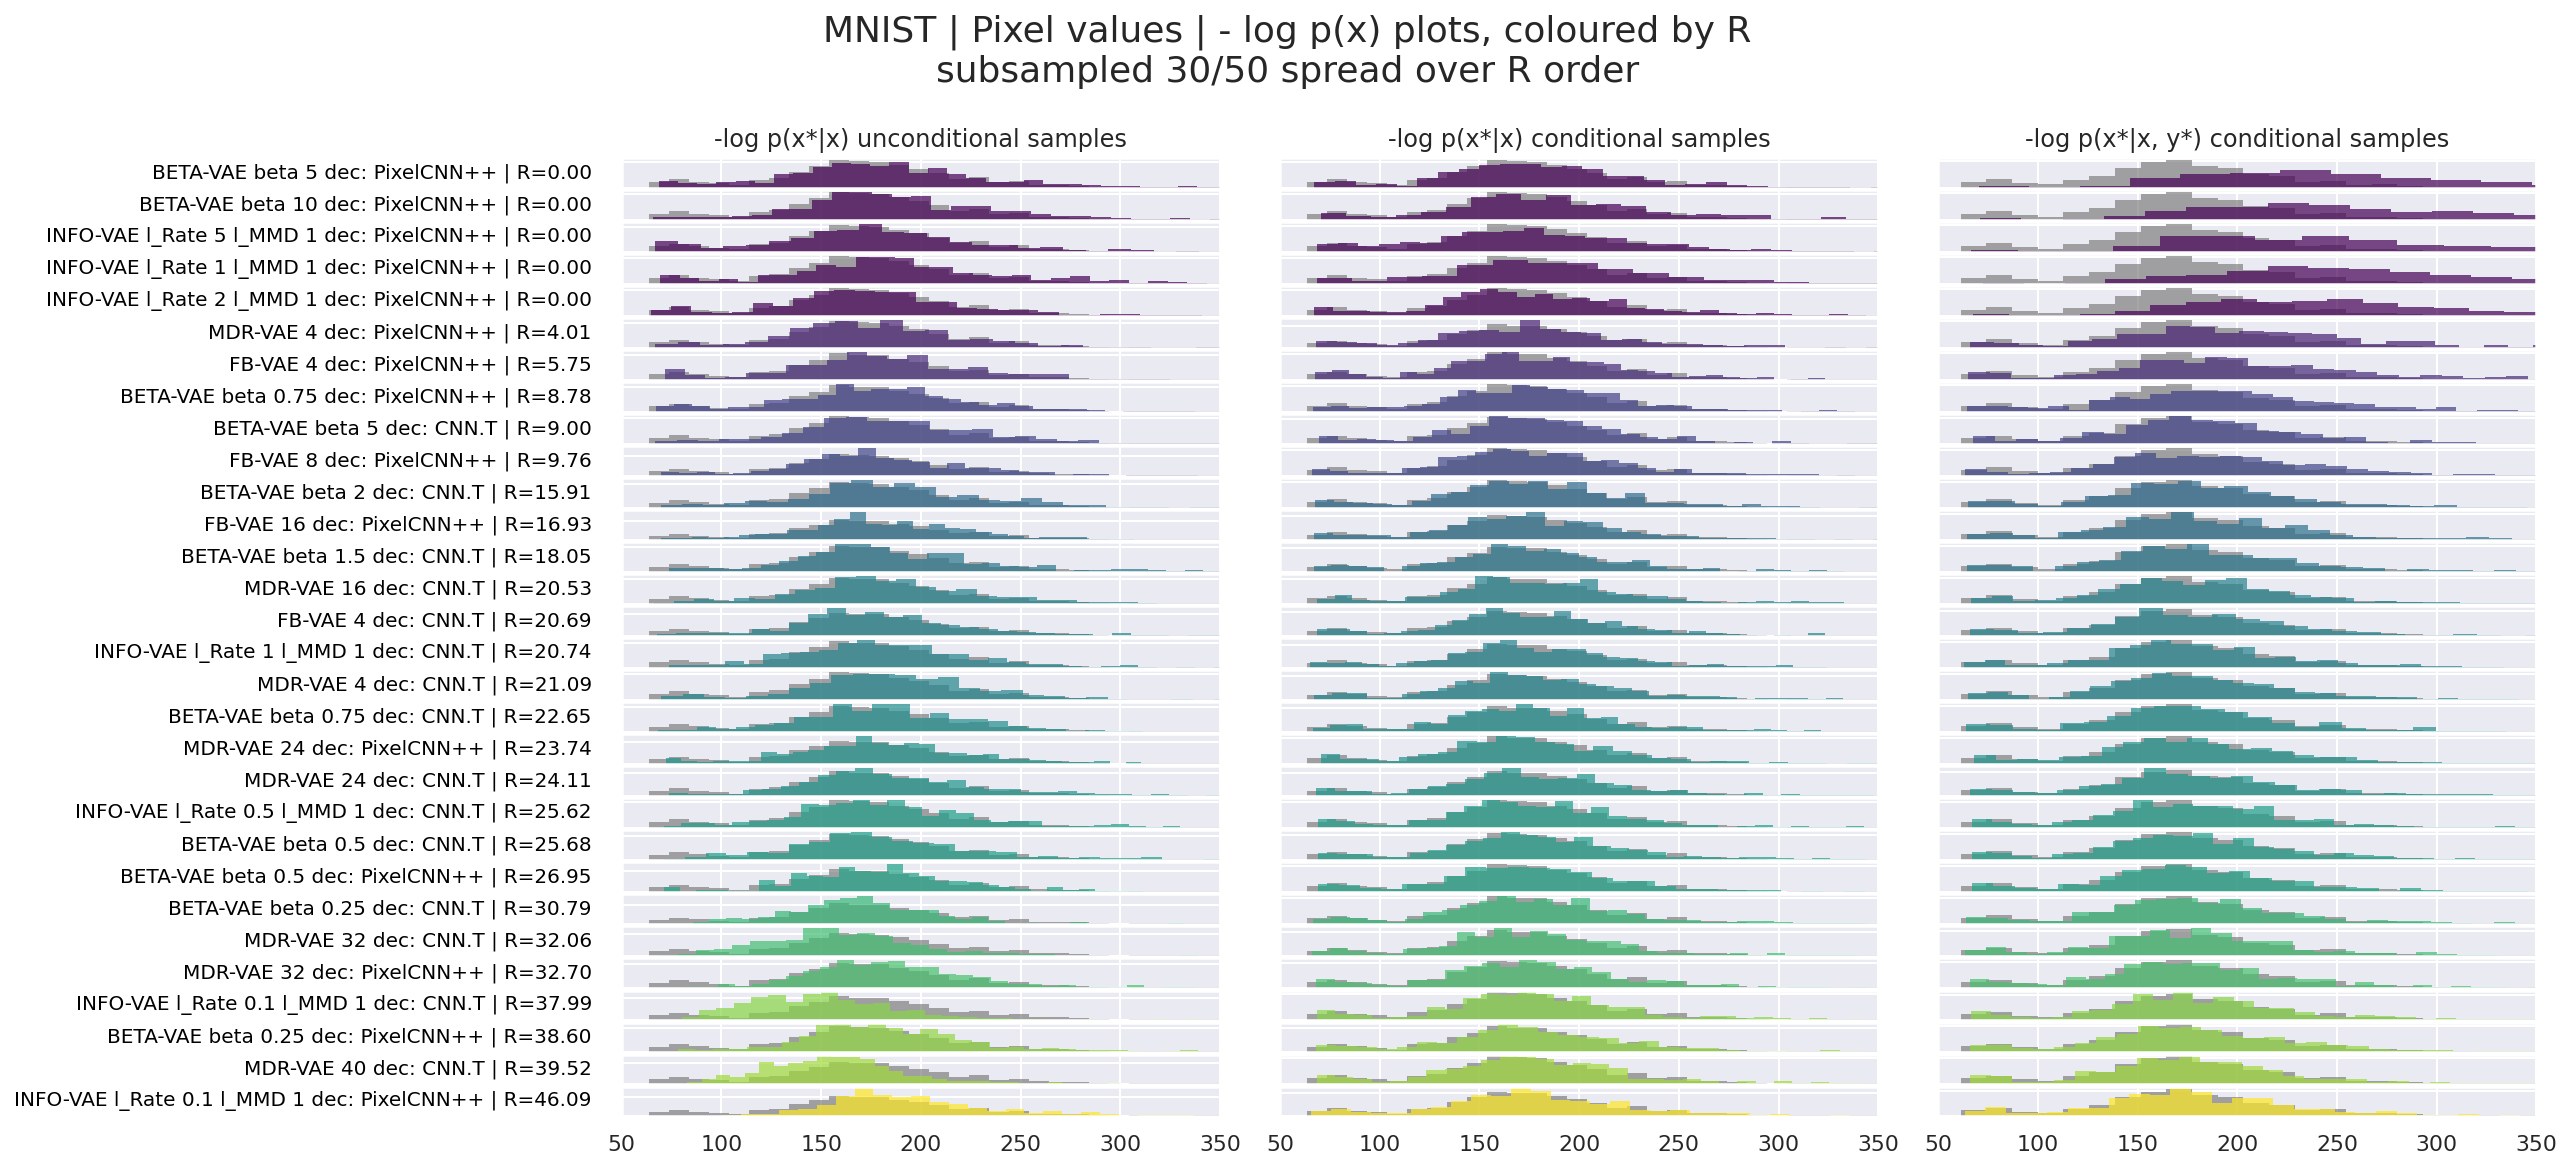

In [60]:
xlims = [[50, 350], [50, 350], [50, 350]]
ylims = [None, None, None]

# Filter our really high rate runs
global_stats_df_filter = global_stats_df[(global_stats_df.l_rate < 100) & (global_stats_df.l_mmd < 100)]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="kl_prior_post", 
                                         dataset_name="MNIST",
                                         latent_structure="Pixel values",
                                         sort_name="R", 
                                         bins=30,
                                         title_size=18,
                                         title_y=1.08,
                                         subsample_nrows=30,
                                         sort_ascend=True, 
                                         row_height=0.25)

Rows: 30, cols: 3, n_groups: 68, len(idxs)=30


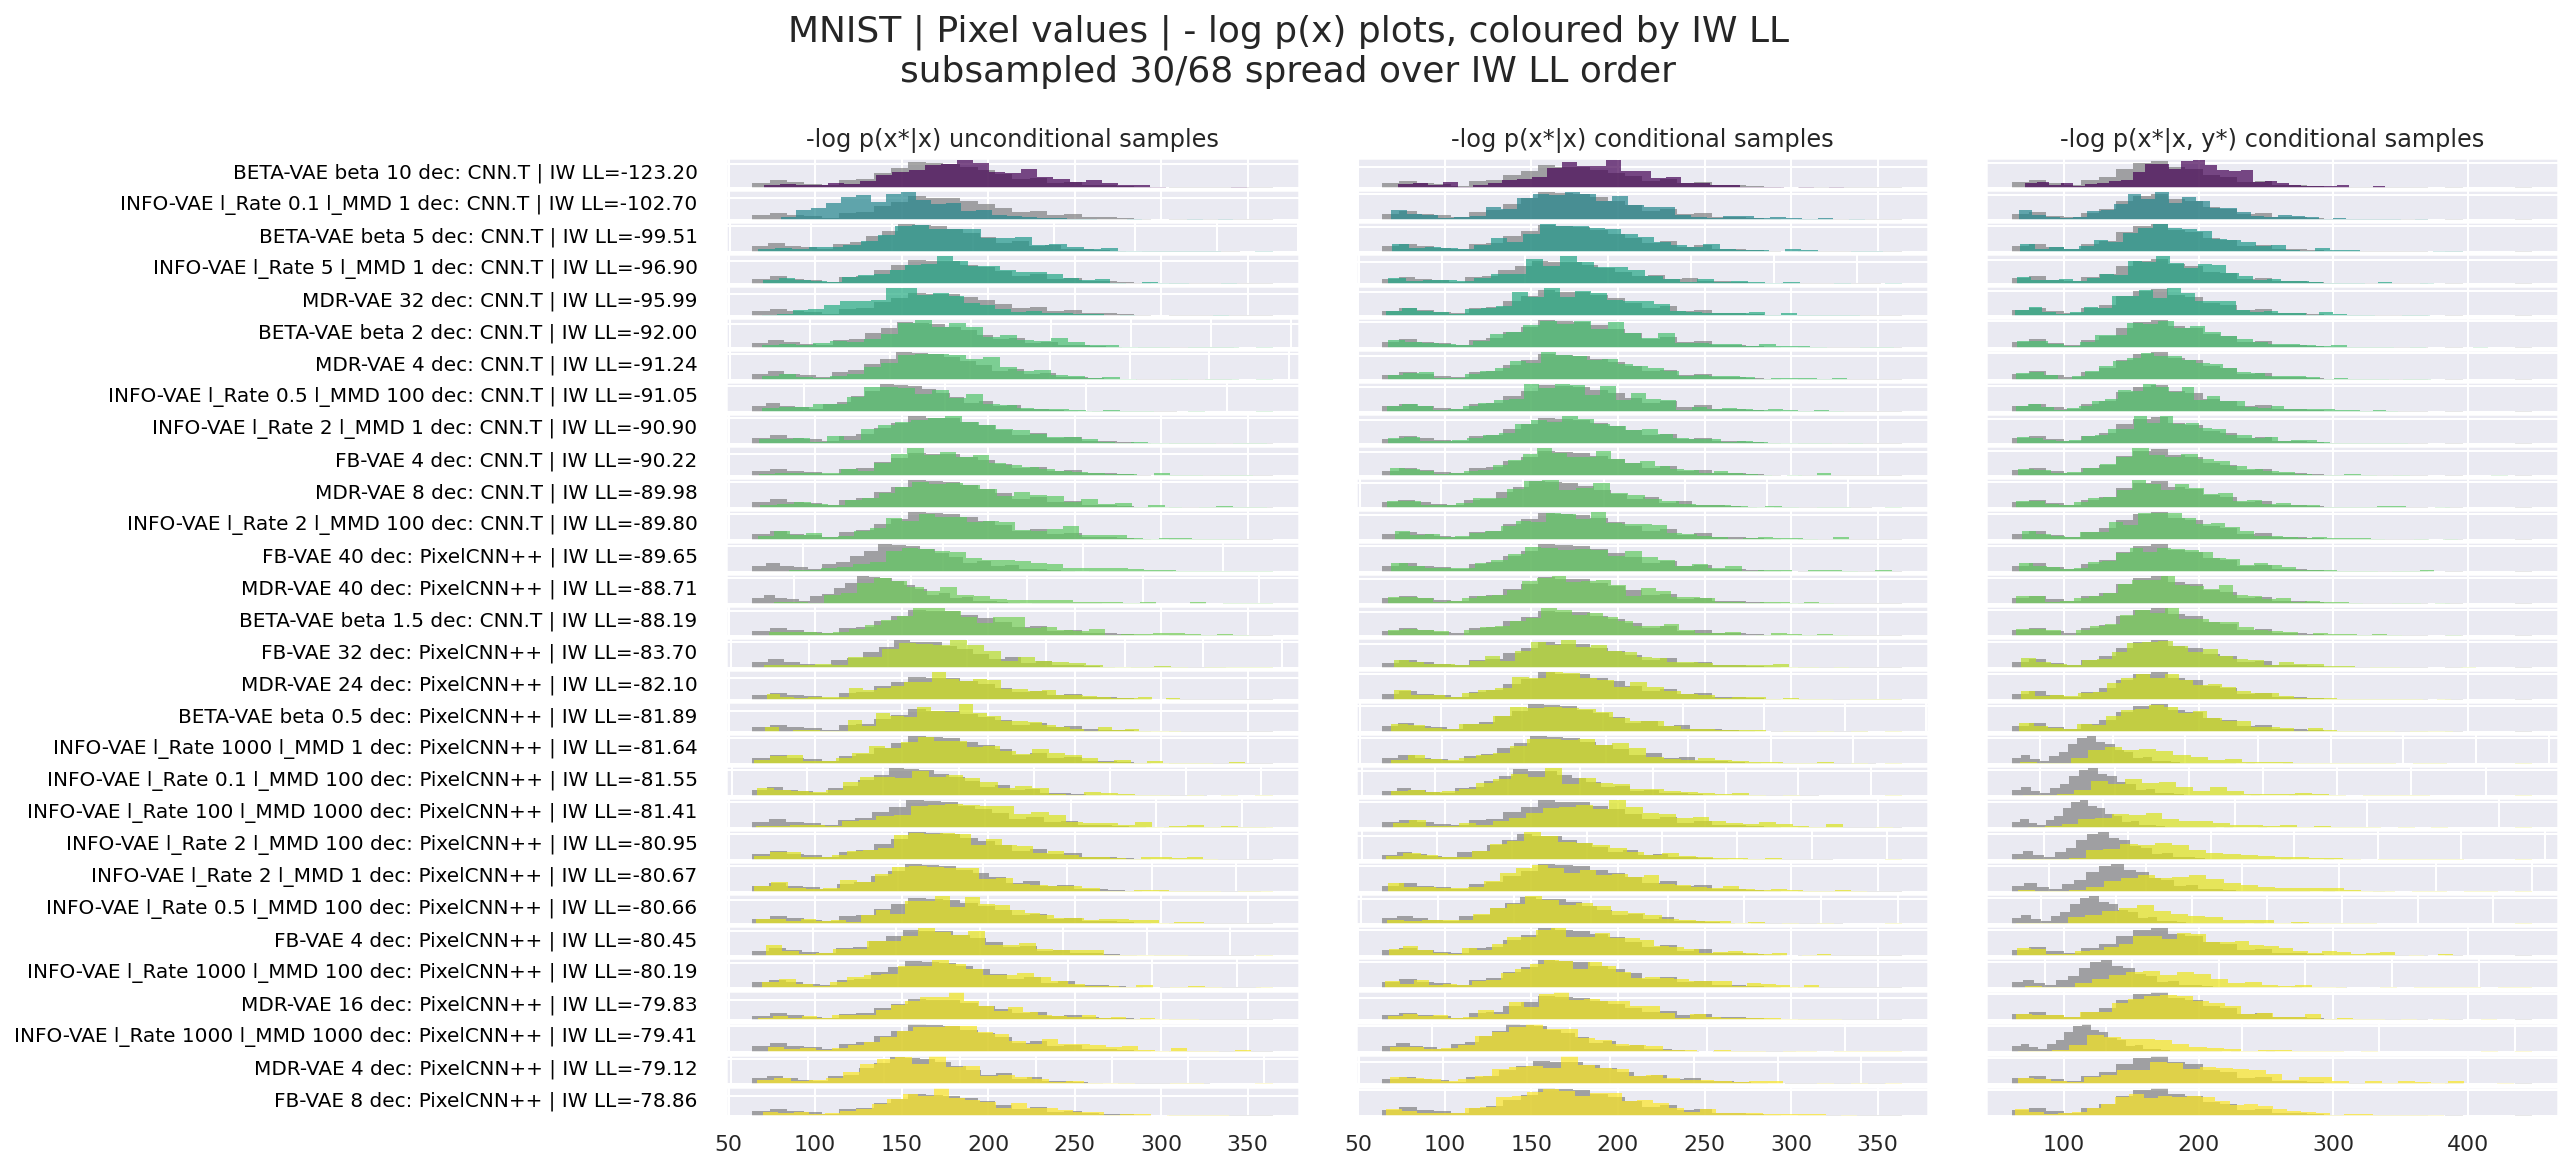

In [61]:
xlims = [None, None, None]
ylims = [None, None, None]

# Filter our really low IW LL runs (or high - IW LL)
global_stats_df_filter = global_stats_df[global_stats_df["IW LL"] > -150.]

plot_surprisal_dists_against_global_stat(global_stats_df=global_stats_df_filter, 
                                         surprisal_values=surprisal_values, 
                                         xlims=xlims,
                                         ylims=ylims,
                                         sort_on="IW LL", 
                                         dataset_name="MNIST",
                                         latent_structure="Pixel values",
                                         sort_name="IW LL", 
                                         bins=30,
                                         title_size=18,
                                         title_y=1.08,
                                         subsample_nrows=30, 
                                         sort_ascend=True, 
                                         row_height=0.25)

# Analyse surprisal distribution with a DP mixture of truncated normals

In [62]:
save_file = "MNIST_surprisal_dp_mixtures.p"
perform_prior_predictive_checks = False
re_compute = False

MAX_SAMPLES_PER_GROUP = 200

NUM_COMPS = 3
NUM_CHAINS = 1
NUM_WARMUP = 100
NUM_SAMPLES = 600

if re_compute:

    dp_mixtures = dict()

    stats = ['unconditional_unconditional', 'unconditional_conditional', 'conditional_conditional']
    for stat_name in stats:

        print(stat_name)

        group_names = []
        observations = []

        for k, v in surprisal_values.items():
            group_names.append(k)
            observations.append(np.array(v[stat_name][:MAX_SAMPLES_PER_GROUP]))

        dp_mixture = DPMixture(
            group_names, 
            observations, 
            obs_dist="truncated_normal", 
            DP_alpha=1., 
            num_comps=NUM_COMPS, 
            num_samples=NUM_SAMPLES, 
            num_chains=NUM_CHAINS, 
            num_warmup=NUM_WARMUP
        )
        
        if perform_prior_predictive_checks:
            prior_samples = dp_mixture.draw_prior_predictions()
            print(tabulate([(k, v.shape) for k, v in prior_samples.items()], headers=['rv', 'shape']))
            _ = plot_predictions(dp_mixture, prior_samples['y'], sharex='row', bins=[30, 30])
            _ = plot_checks(dp_mixture, prior_samples['y'])

        dp_mixture.run()

        dp_mixtures[stat_name] = dp_mixture
        
    pickle.dump(dp_mixtures, open(save_file, "wb"))
    
else:
    dp_mixtures = pickle.load(open(save_file, "rb"))

# Posterior checks & plots for DP

In [16]:
# def plot_predictions(model, samples, bins=[20, 100], density=[True, True], sharex=True, sharey=True):
#     fig, ax = plt.subplots(model.G, 2, sharex=sharex, sharey=sharey, figsize=(10, 3*model.G))
#     if model.G == 1:
#         ax = ax.reshape(1, -1)
#     pal = cycle(sns.color_palette())
#     for k in range(model.G):
#         yk = model.obs_y[model.obs_g == k]
#         yk_ = samples[:, model.obs_g == k]
#         c = next(pal)
#         _ = ax[k, 0].hist(yk, bins=bins[0], color=c, density=density[0])
#         _ = ax[k, 0].set_xlabel(f'obs: {model.group_names[k]}')
#         _ = ax[k, 1].hist(yk_.flatten(), bins=bins[1], color=c, density=density[1])
#         _ = ax[k, 1].set_xlabel(f'predictive: {model.group_names[k]}')

#     fig.tight_layout(h_pad=2, w_pad=2)
#     fig.show()

# def plot_checks(model, samples, bins=30):
#     fig, ax = plt.subplots(model.G, 4, figsize=(10, model.G*3))

#     if model.G == 1:
#         ax = ax.reshape(1, -1)

#     pal = cycle(sns.color_palette())

#     for k in range(model.G):
#         c = next(pal)
#         yk = model.obs_y[model.obs_g == k]
#         yk_ = samples[:, model.obs_g == k]

#         _ = ax[k, 0].hist(np.mean(yk_, 1), bins=bins, color=c, label='pred' if k == 0 else None)
#         _ = ax[k, 0].axvline(np.mean(yk), color='black', linestyle='--', label='obs' if k == 0 else None)
#         _ = ax[k, 0].set_xlabel(f'E[Y{k}]')

#         _ = ax[k, 1].hist(np.std(yk_, 1), color=c, bins=bins)
#         _ = ax[k, 1].axvline(np.std(yk), color='black', linestyle='--')
#         _ = ax[k, 1].set_xlabel(f'std[Y{k}]')

#         _ = ax[k, 2].hist(np.median(yk_, 1), color=c, bins=bins)
#         _ = ax[k, 2].axvline(np.median(yk), color='black', linestyle='--')
#         _ = ax[k, 2].set_xlabel(f'median[Y{k}]')

#         pvalues = np.mean(yk_ > yk, 1)
#         _ = ax[k, 3].hist(pvalues, bins=bins)
#         _ = ax[k, 3].set_xlabel(f'Pr(Y{k} > obs{k})')
#         _ = ax[k, 3].axvline(np.median(pvalues), color='black', linestyle=':', label='median' if k == 0 else None)

#     _ = fig.legend(loc='upper center', ncol=3)
#     fig.tight_layout(h_pad=2, w_pad=2)
#     fig.show()

I0114 09:38:04.260046 22616468008704 tpu_client.py:54] Starting the local TPU driver.
I0114 09:38:04.262160 22616468008704 xla_bridge.py:231] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
I0114 09:38:04.263354 22616468008704 xla_bridge.py:231] Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
I0114 09:38:04.264936 22616468008704 xla_bridge.py:231] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


UNCONDITIONAL_UNCONDITIONAL


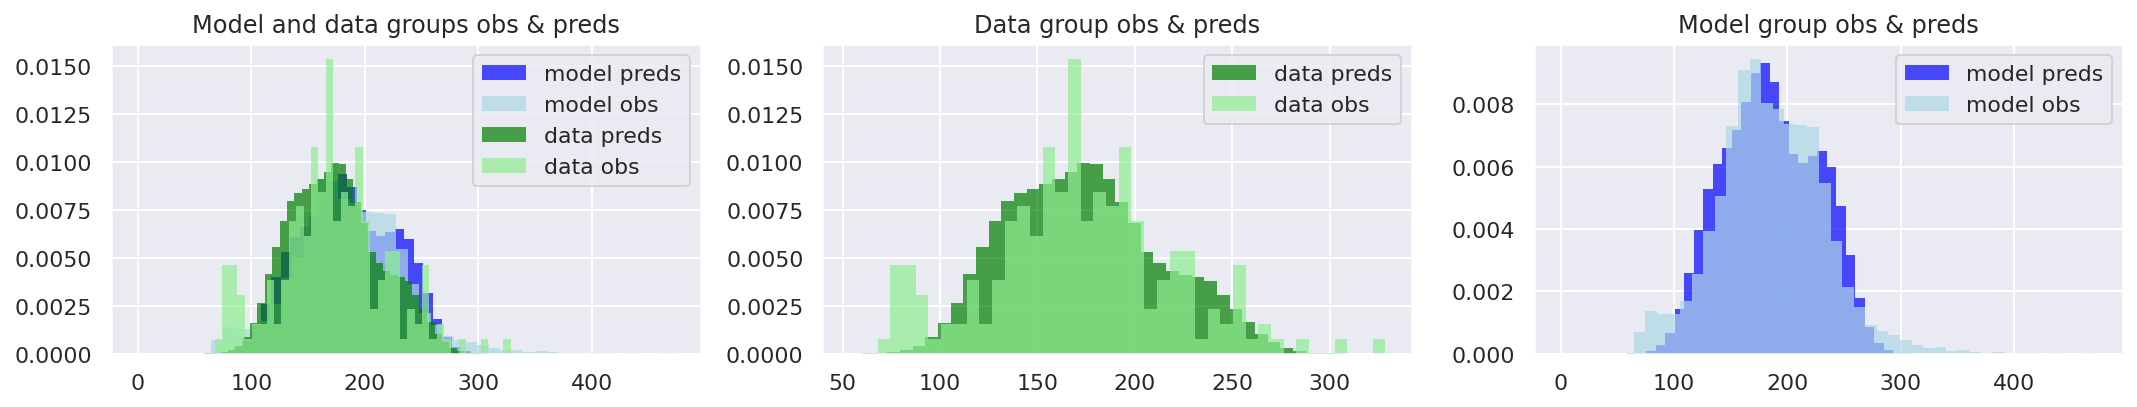

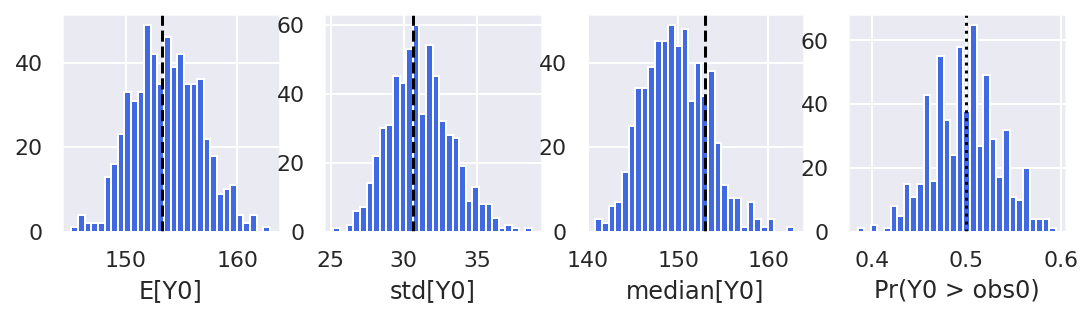

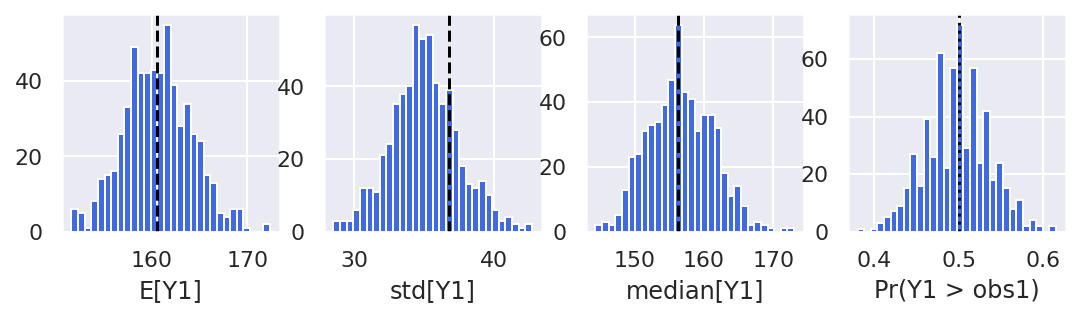

UNCONDITIONAL_CONDITIONAL


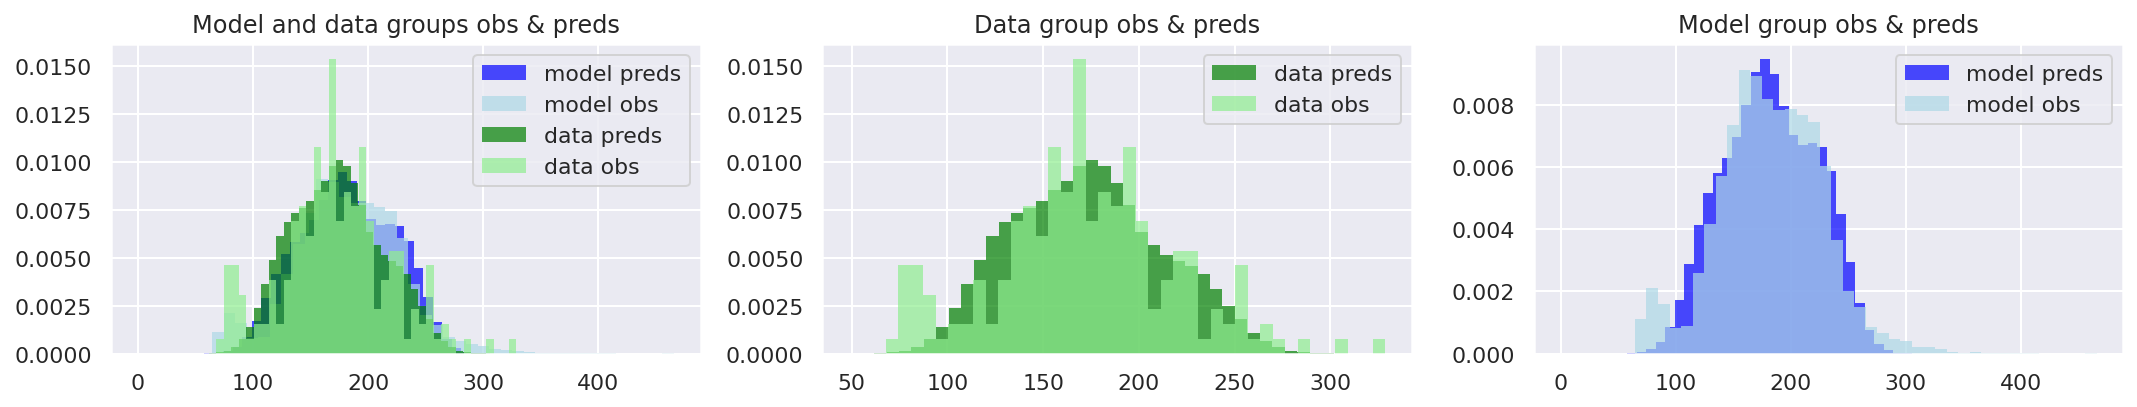

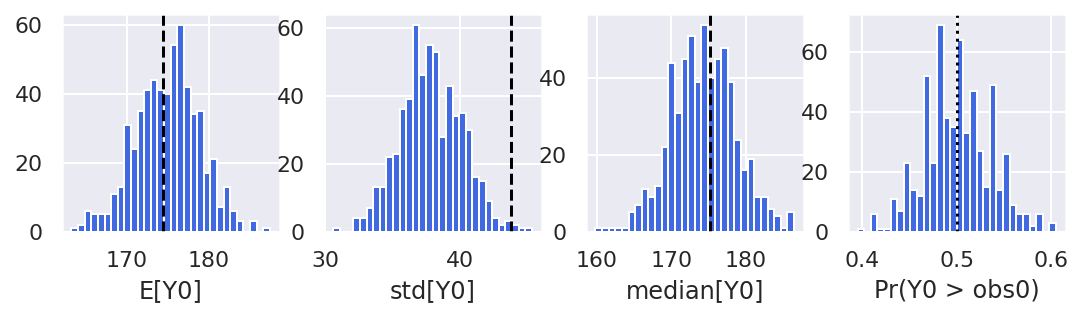

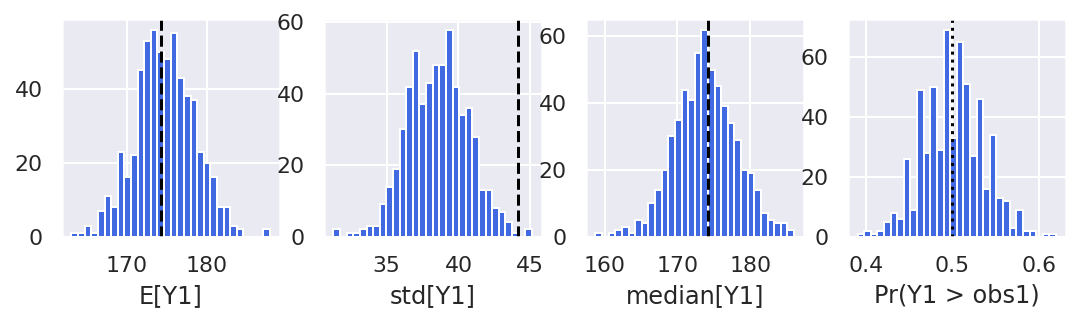

CONDITIONAL_CONDITIONAL


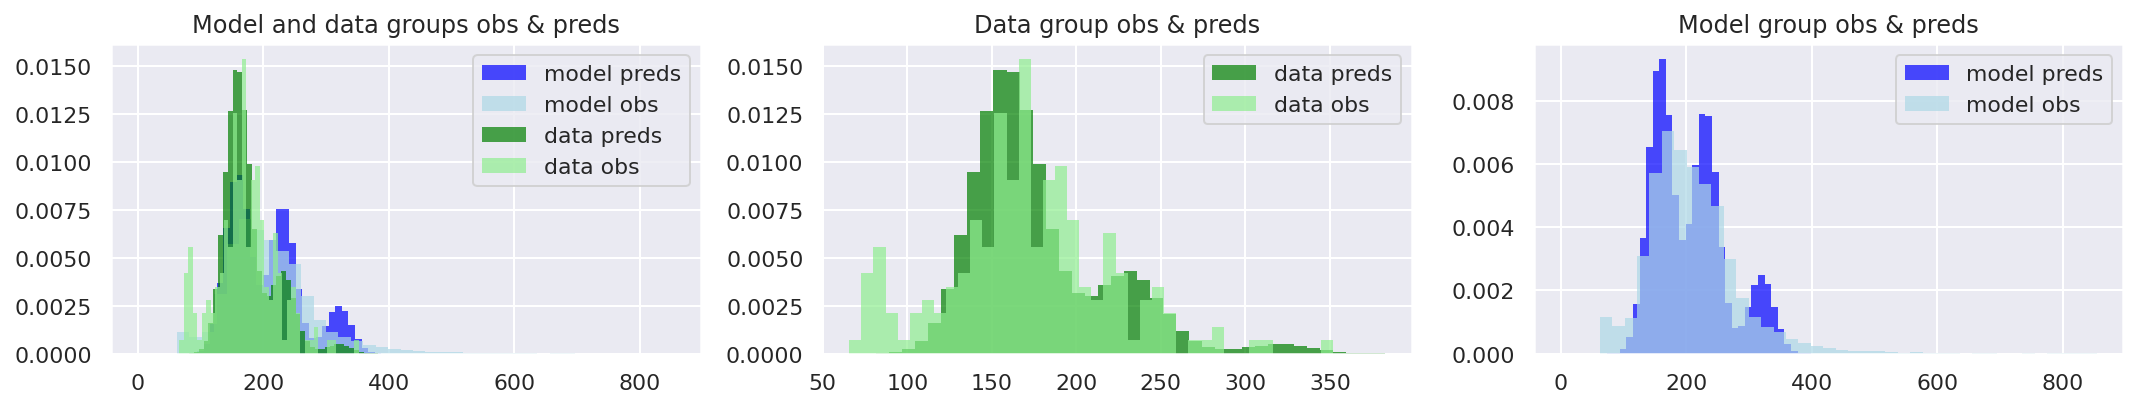

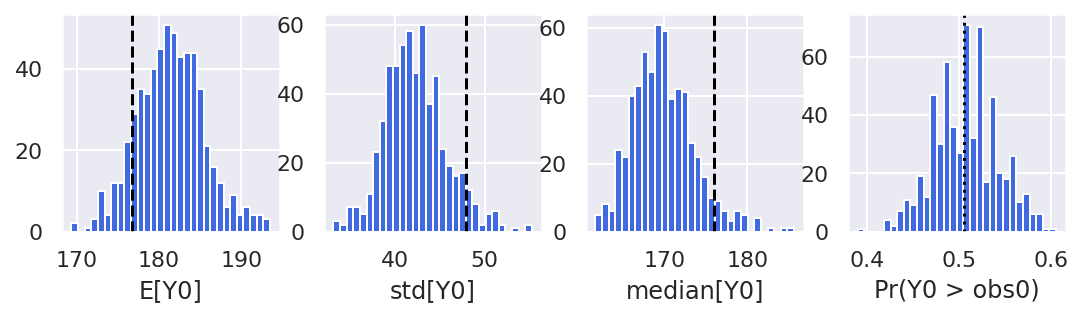

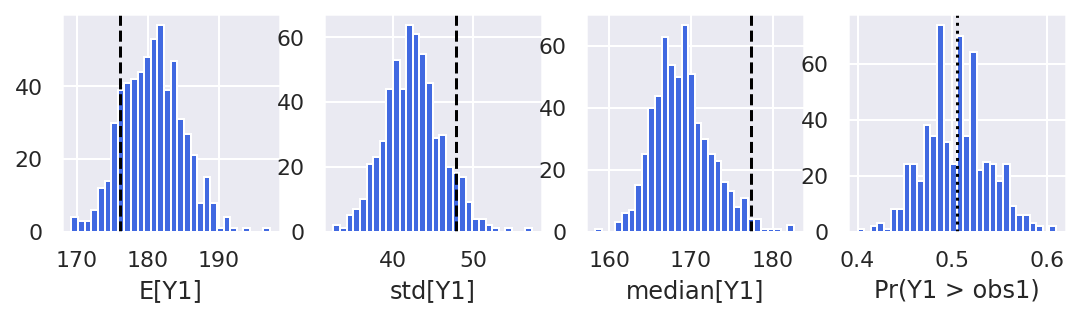

In [63]:
for stat, dp_mixture in dp_mixtures.items():
    print(stat.upper())

    plot_model_data_preds_obs(dp_mixture)
    samples = dp_mixture.draw_posterior_predictions()["y"]
    surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=2)
    # plot_all_groups_preds_obs(dp_mixture)

UNCONDITIONAL_UNCONDITIONAL


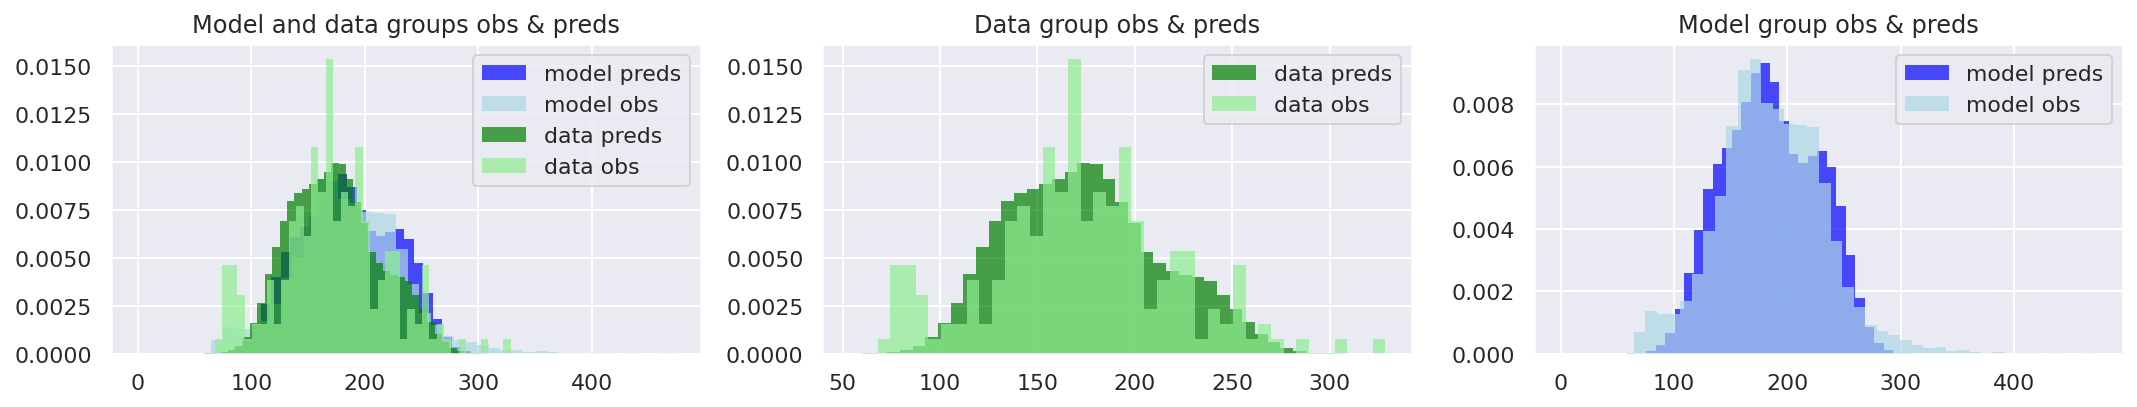

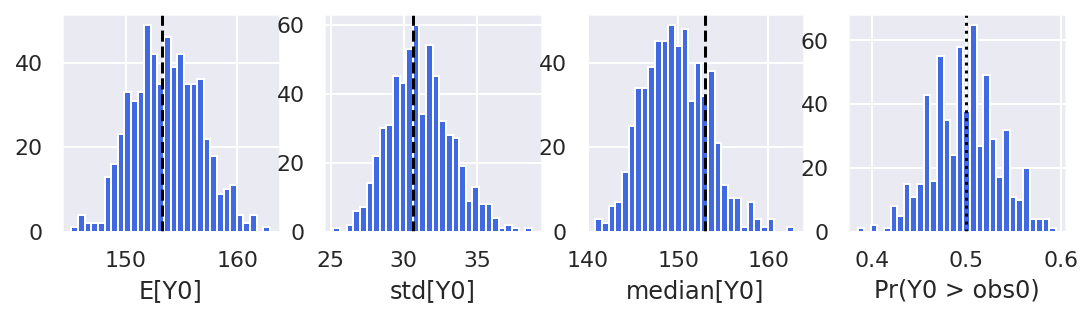

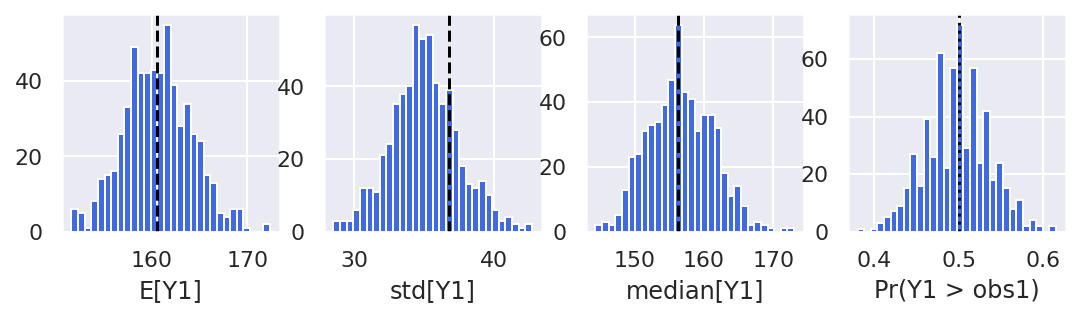

UNCONDITIONAL_CONDITIONAL


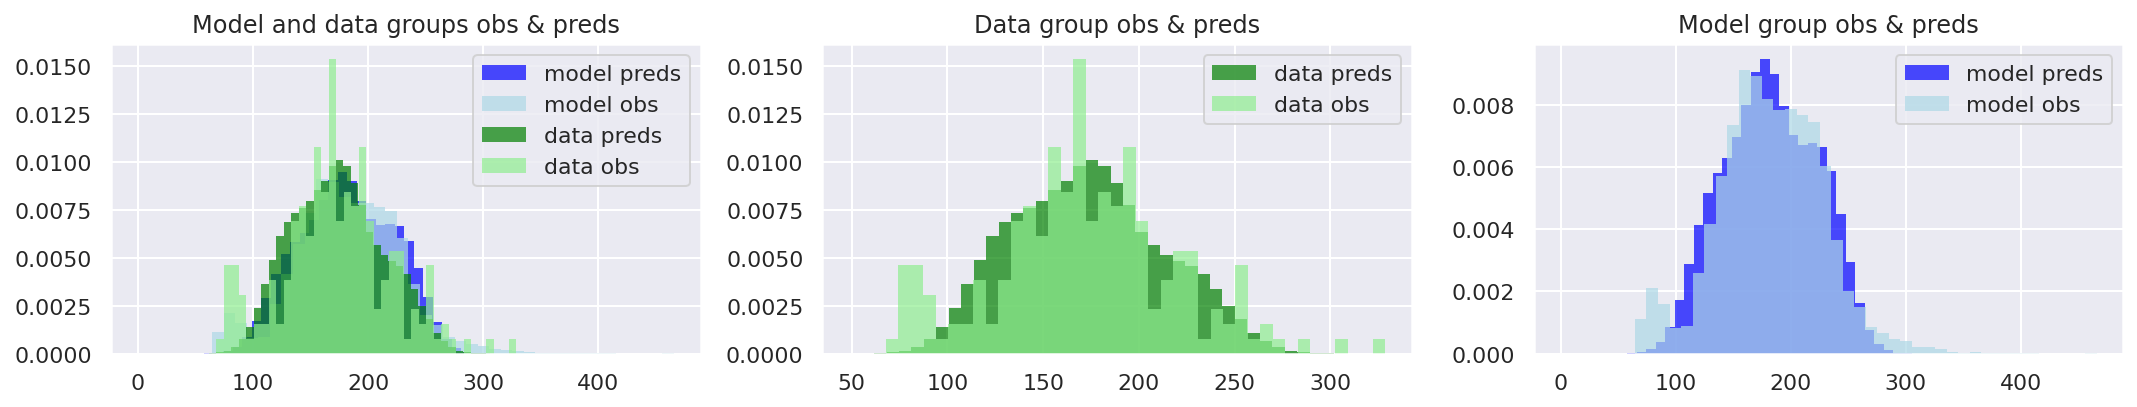

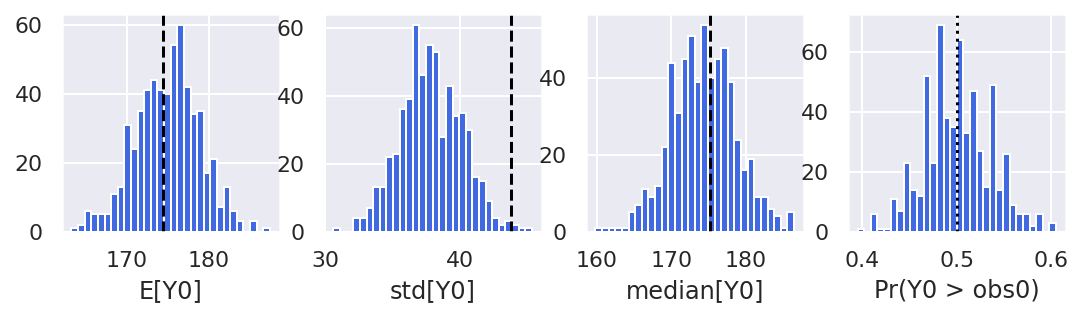

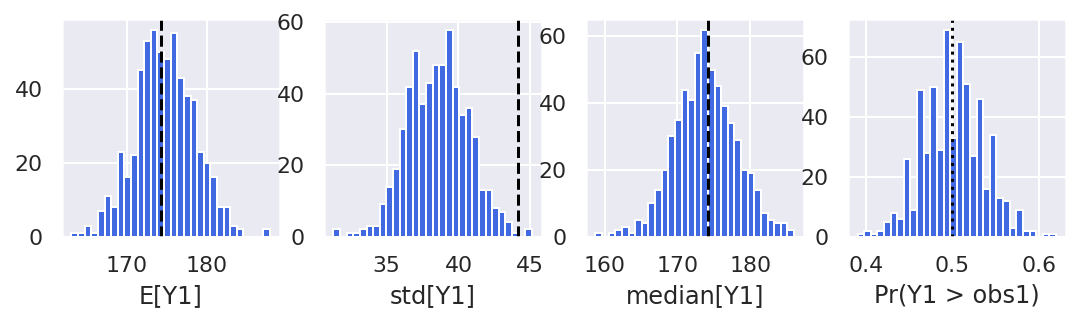

CONDITIONAL_CONDITIONAL


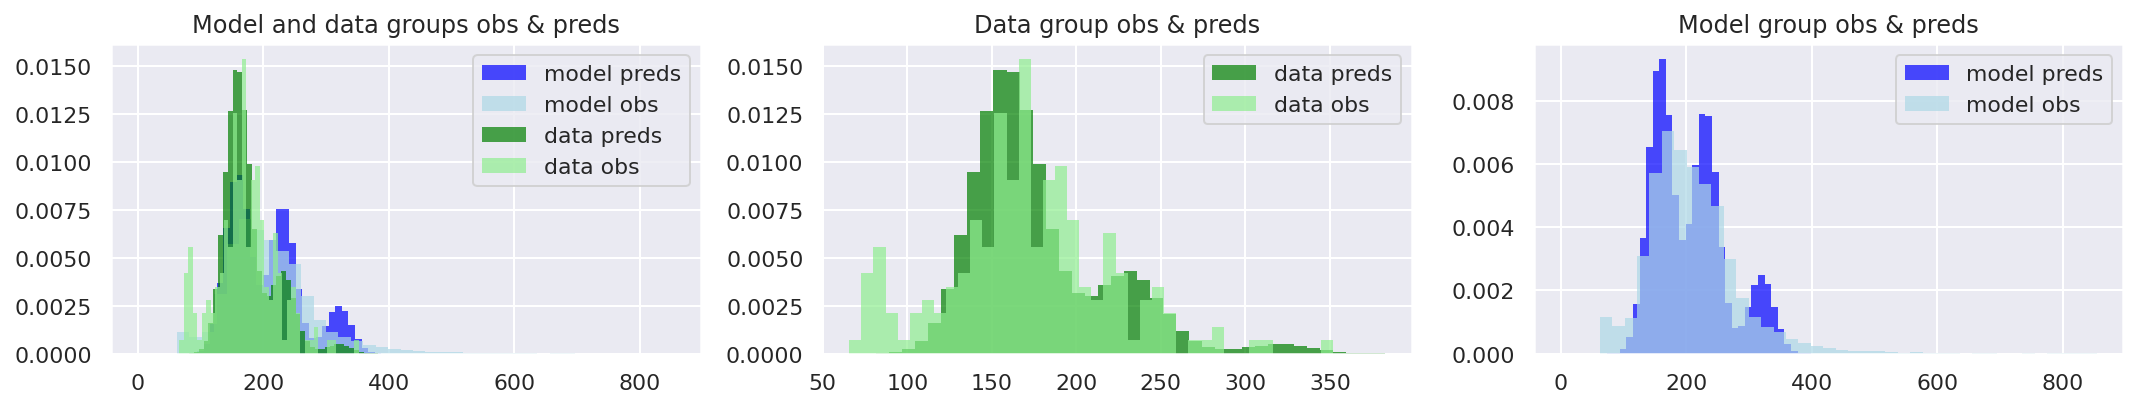

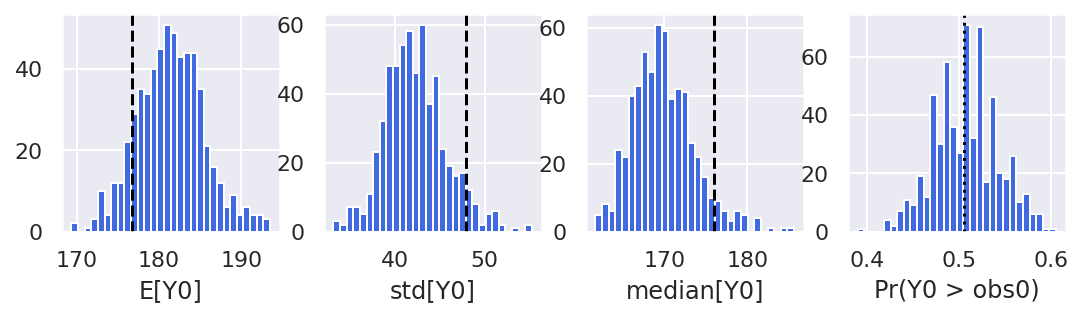

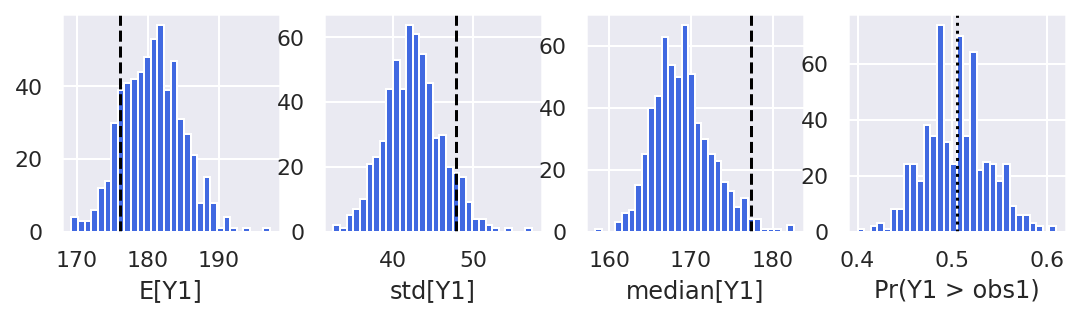

In [17]:
for stat, dp_mixture in dp_mixtures.items():
    print(stat.upper())

    plot_model_data_preds_obs(dp_mixture)
    samples = dp_mixture.draw_posterior_predictions()["y"]
    surprisal_dp_plot_checks(dp_mixture, samples, plot_max_groups=2)
    # plot_all_groups_preds_obs(dp_mixture)

# Now assess "divergence" from model sample surprisal values from data group in three ways:

1. KL between component assignments under the DP Mixture
2. Difference between estimated densities under the DP Mixture
3. Wasserstein distance between surprisal value histograms (no DP Mixture used)

In [70]:
all_df = compute_all_divergences_data_model_groups(dp_mixtures, surprisal_values)
global_stats_df_select = global_stats_df[(global_stats_df.l_rate < 100) & (global_stats_df.l_mmd < 1000)]
all_df_select = all_df[all_df.index.isin(global_stats_df_select.index)]

UNCONDITIONAL_UNCONDITIONAL
UNCONDITIONAL_CONDITIONAL
CONDITIONAL_CONDITIONAL


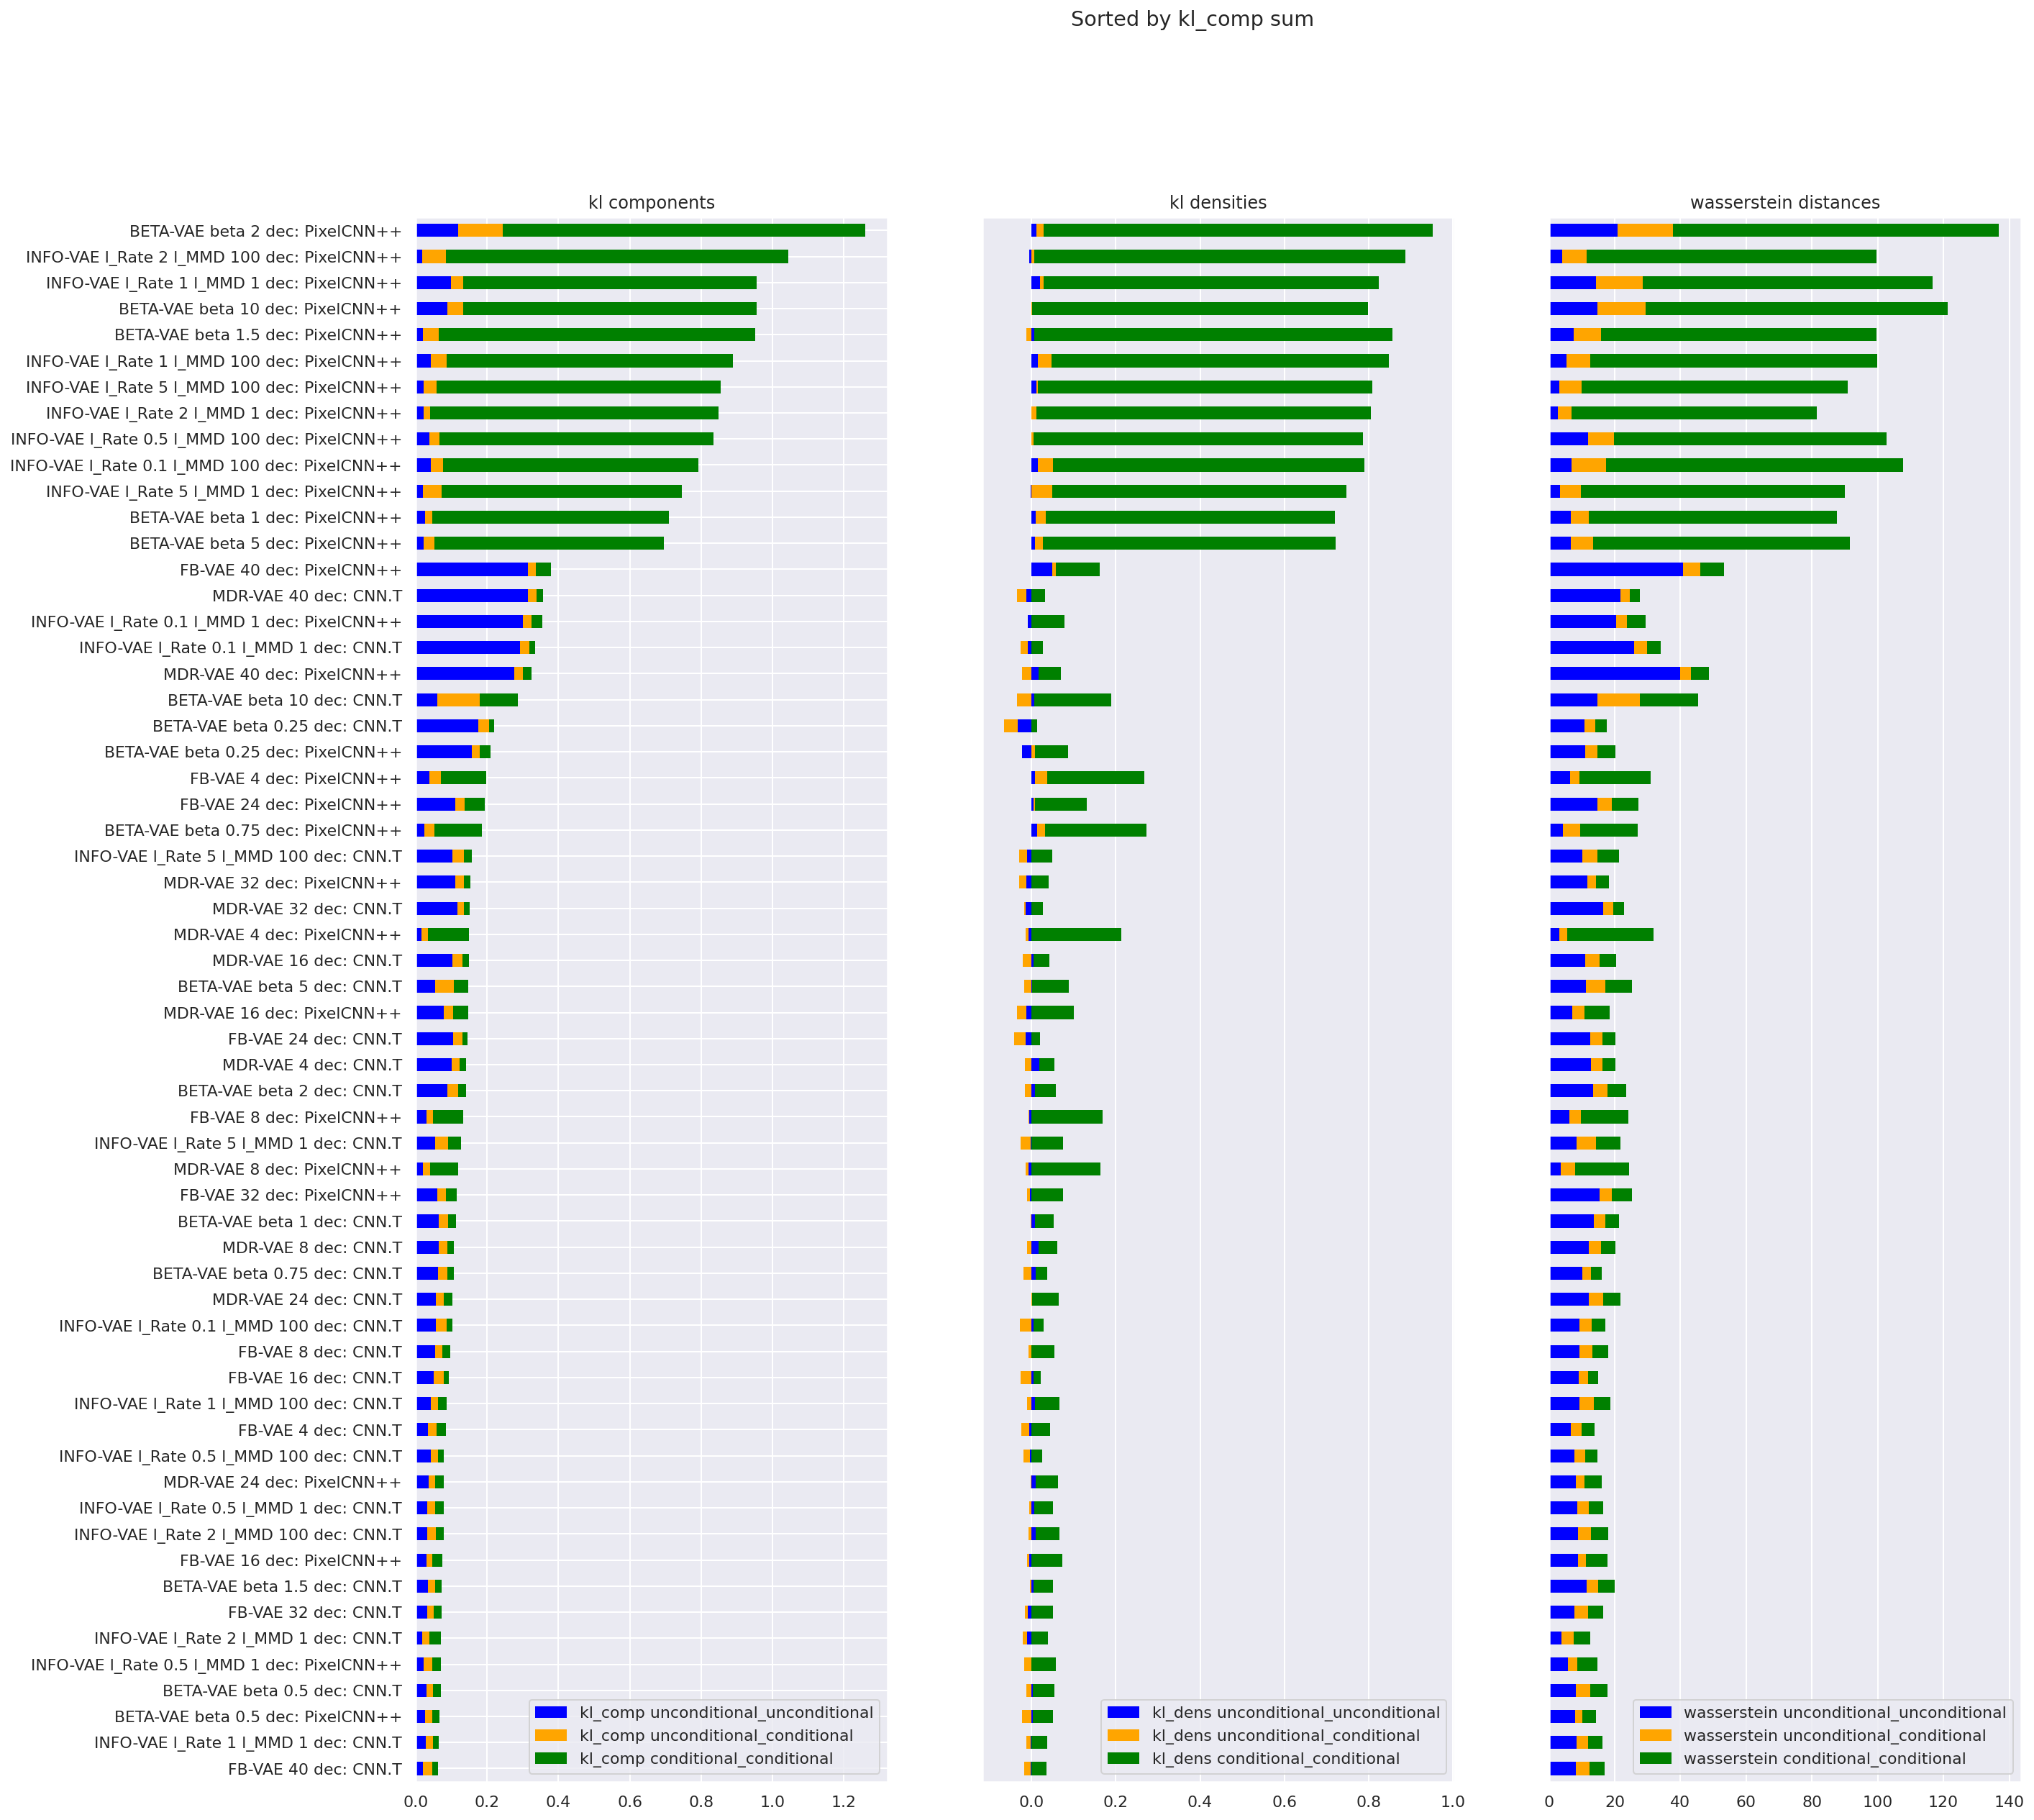

In [71]:
SORT_ON = "kl_comp sum"
plot_divergences_data_model_groups(all_df_select, sort_on=SORT_ON, plot_only=None)

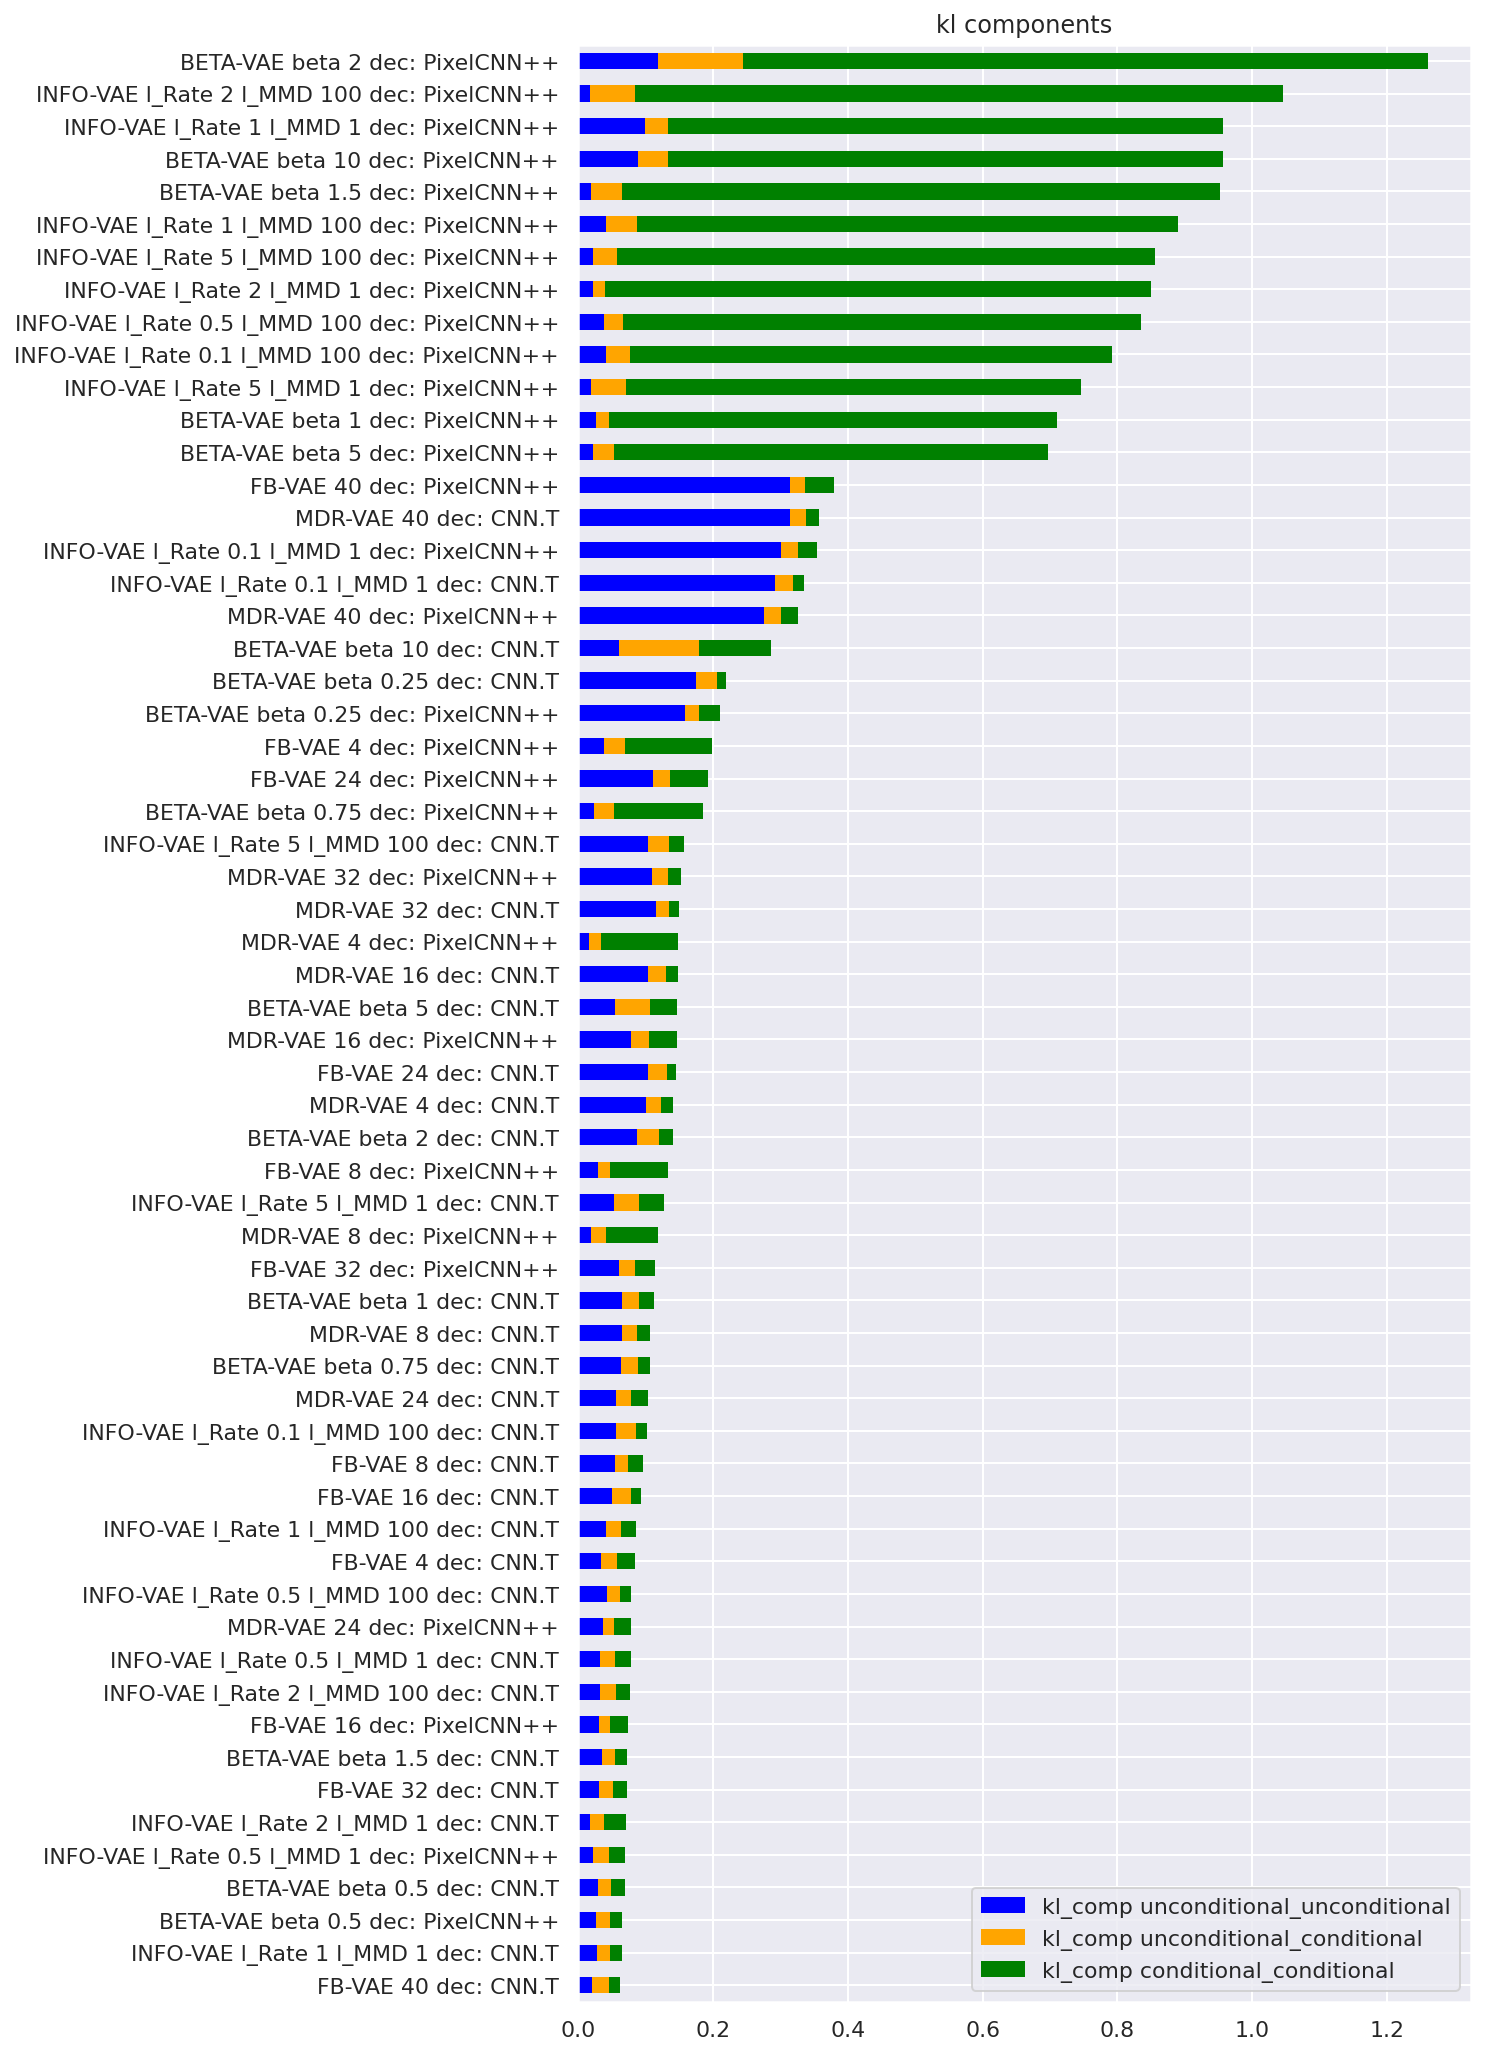

In [72]:
plot_divergences_data_model_groups(all_df_select, sort_on=SORT_ON, plot_only="kl_comp", figsize=(8, 18))

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


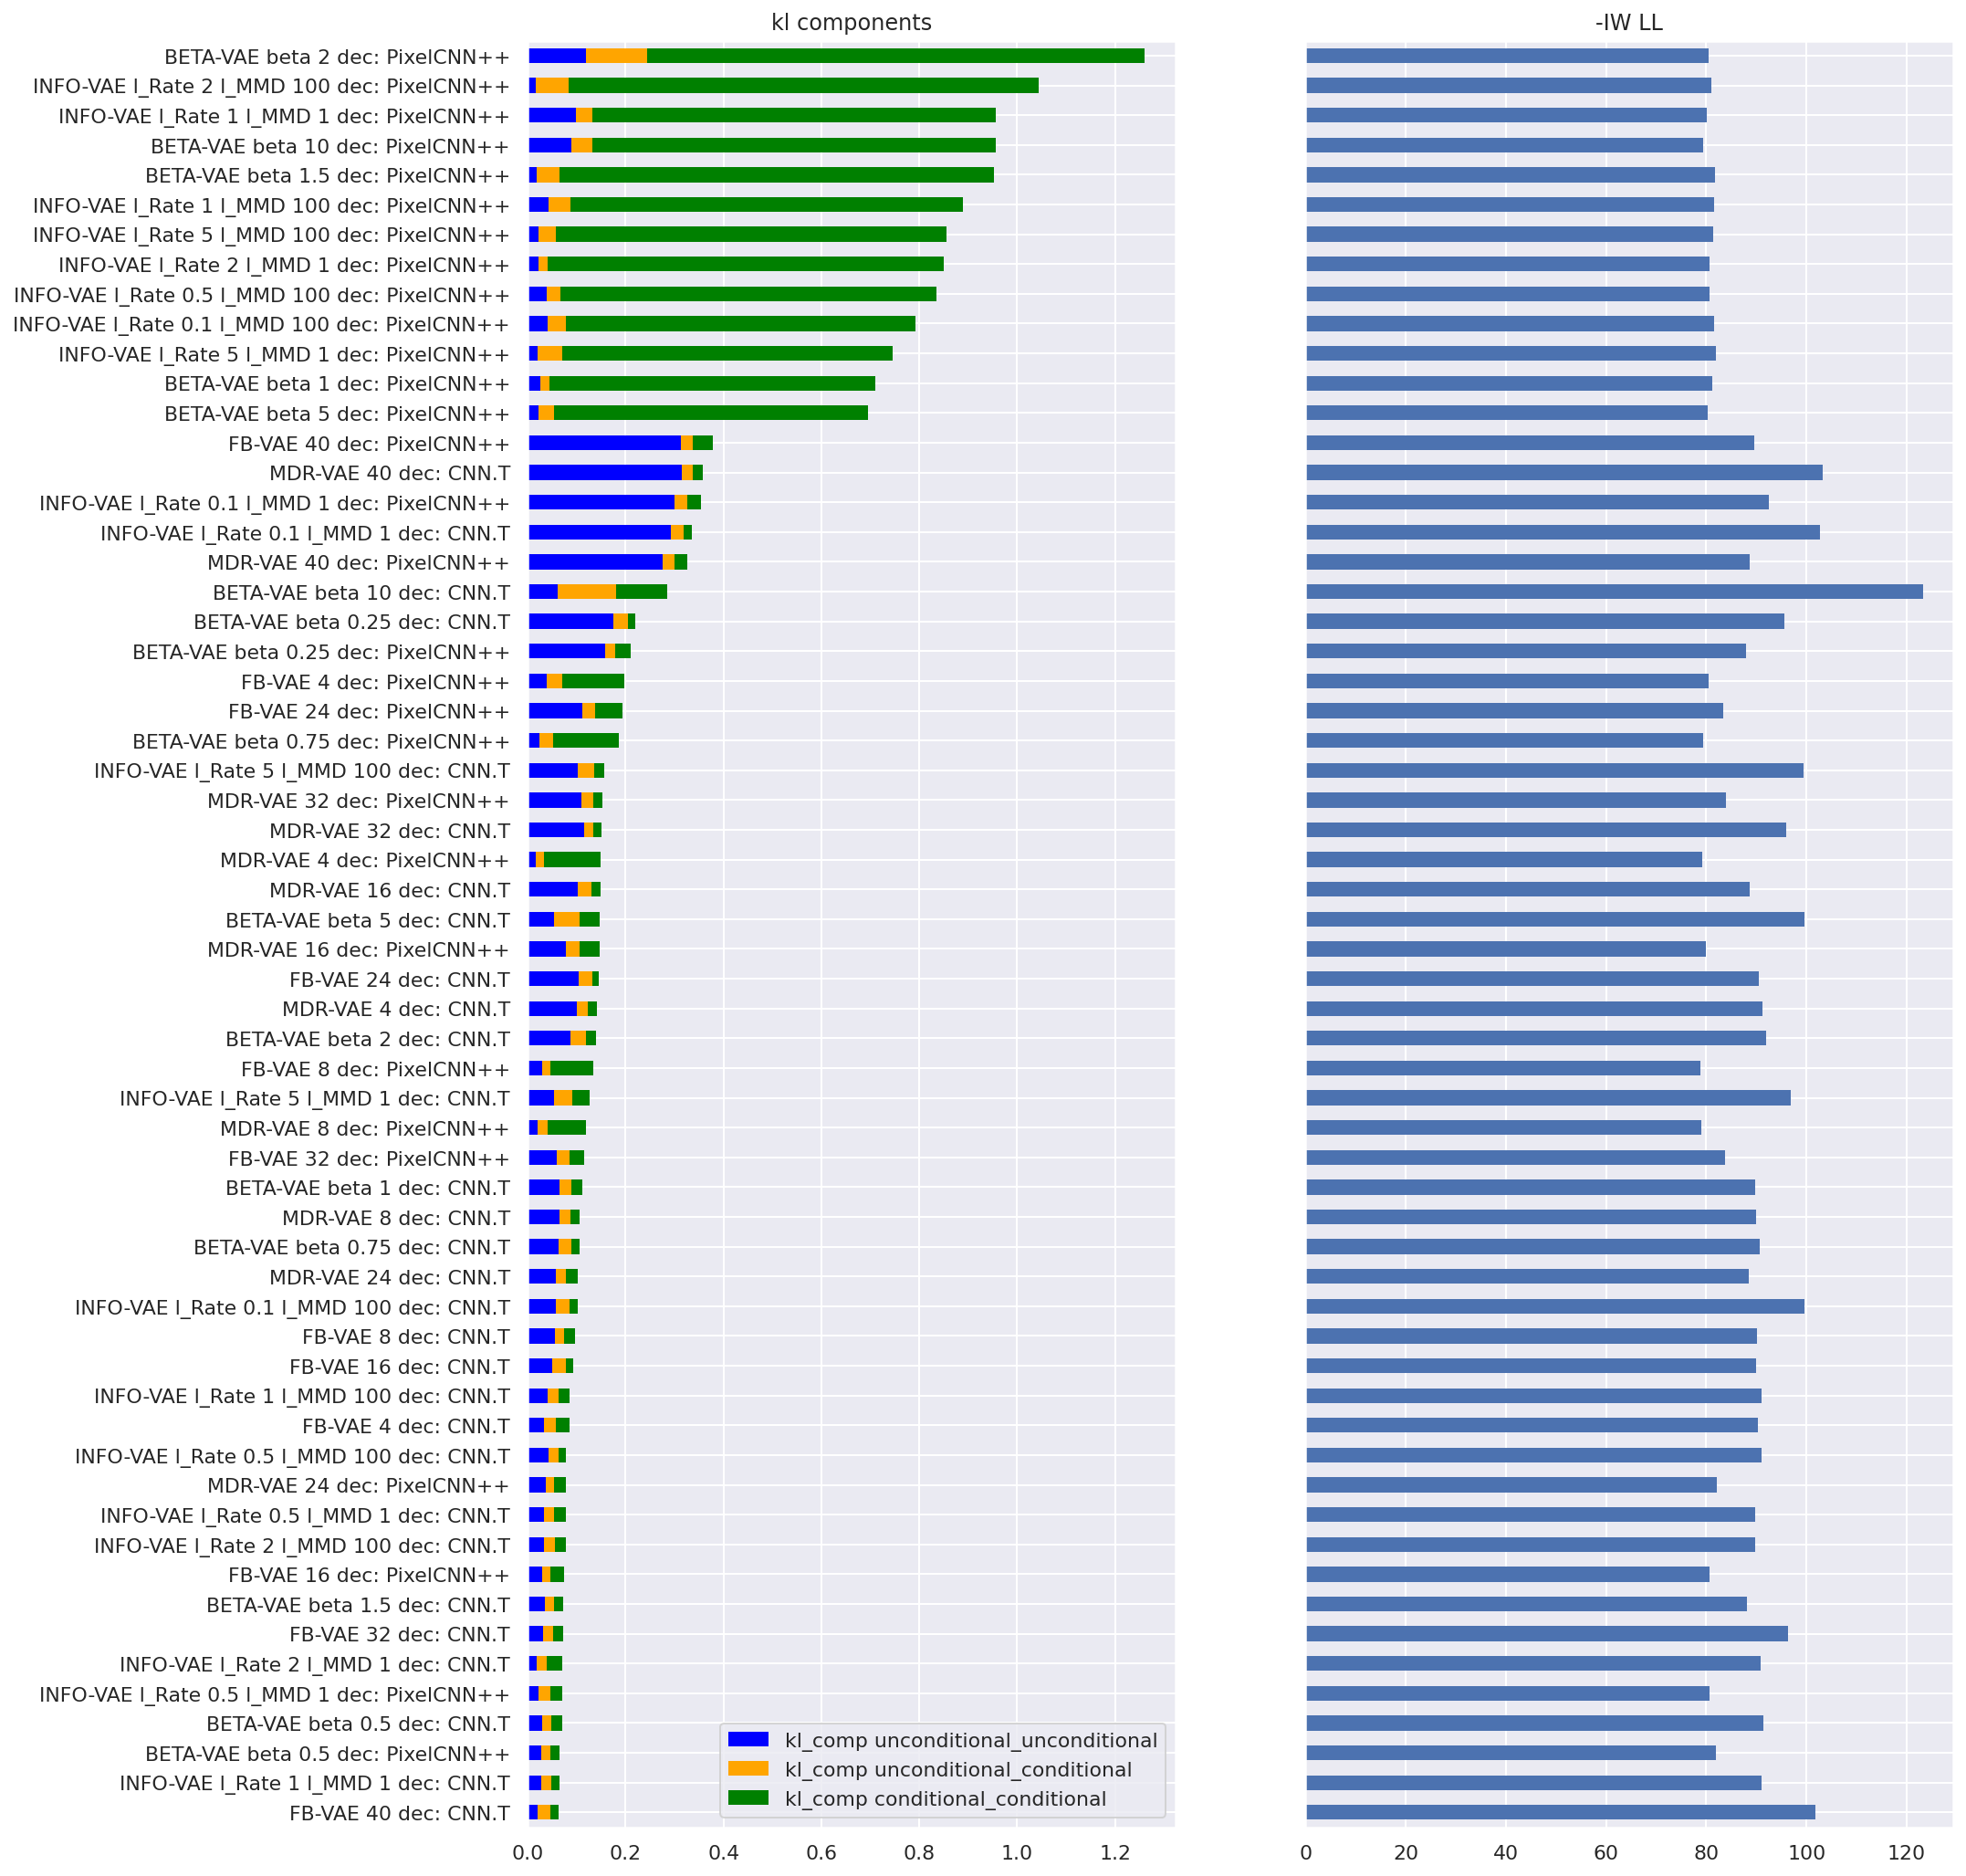

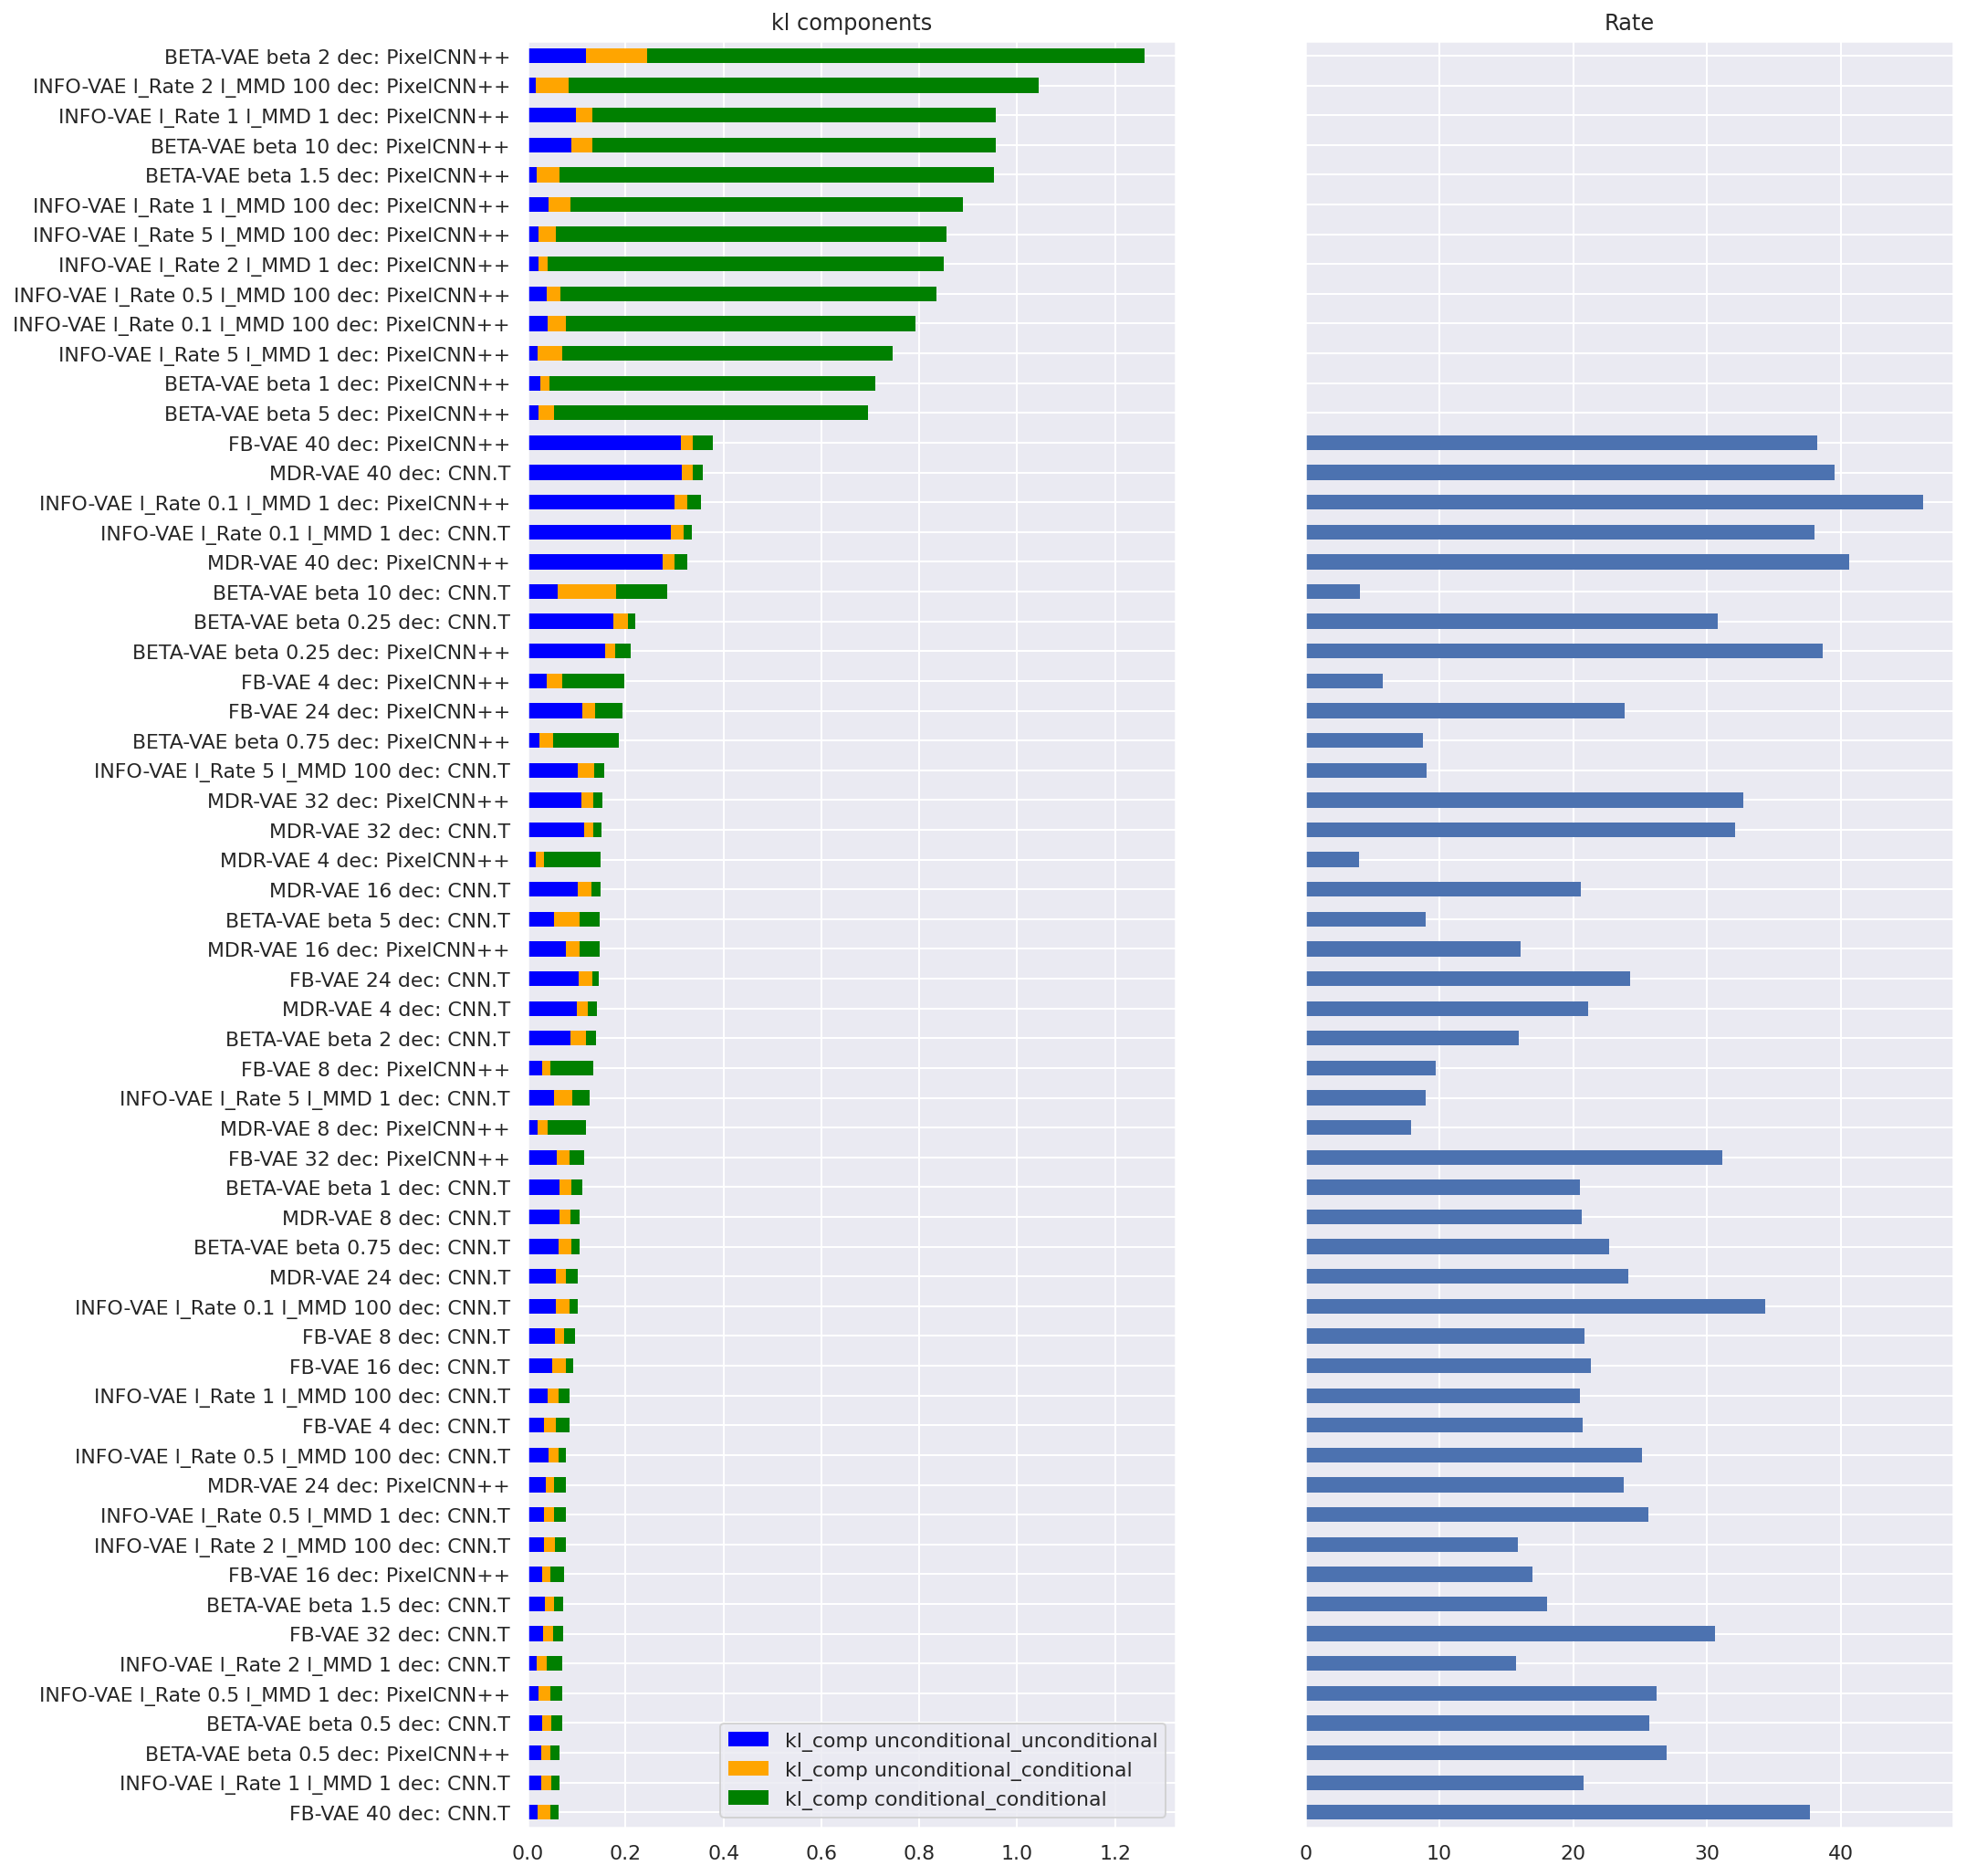

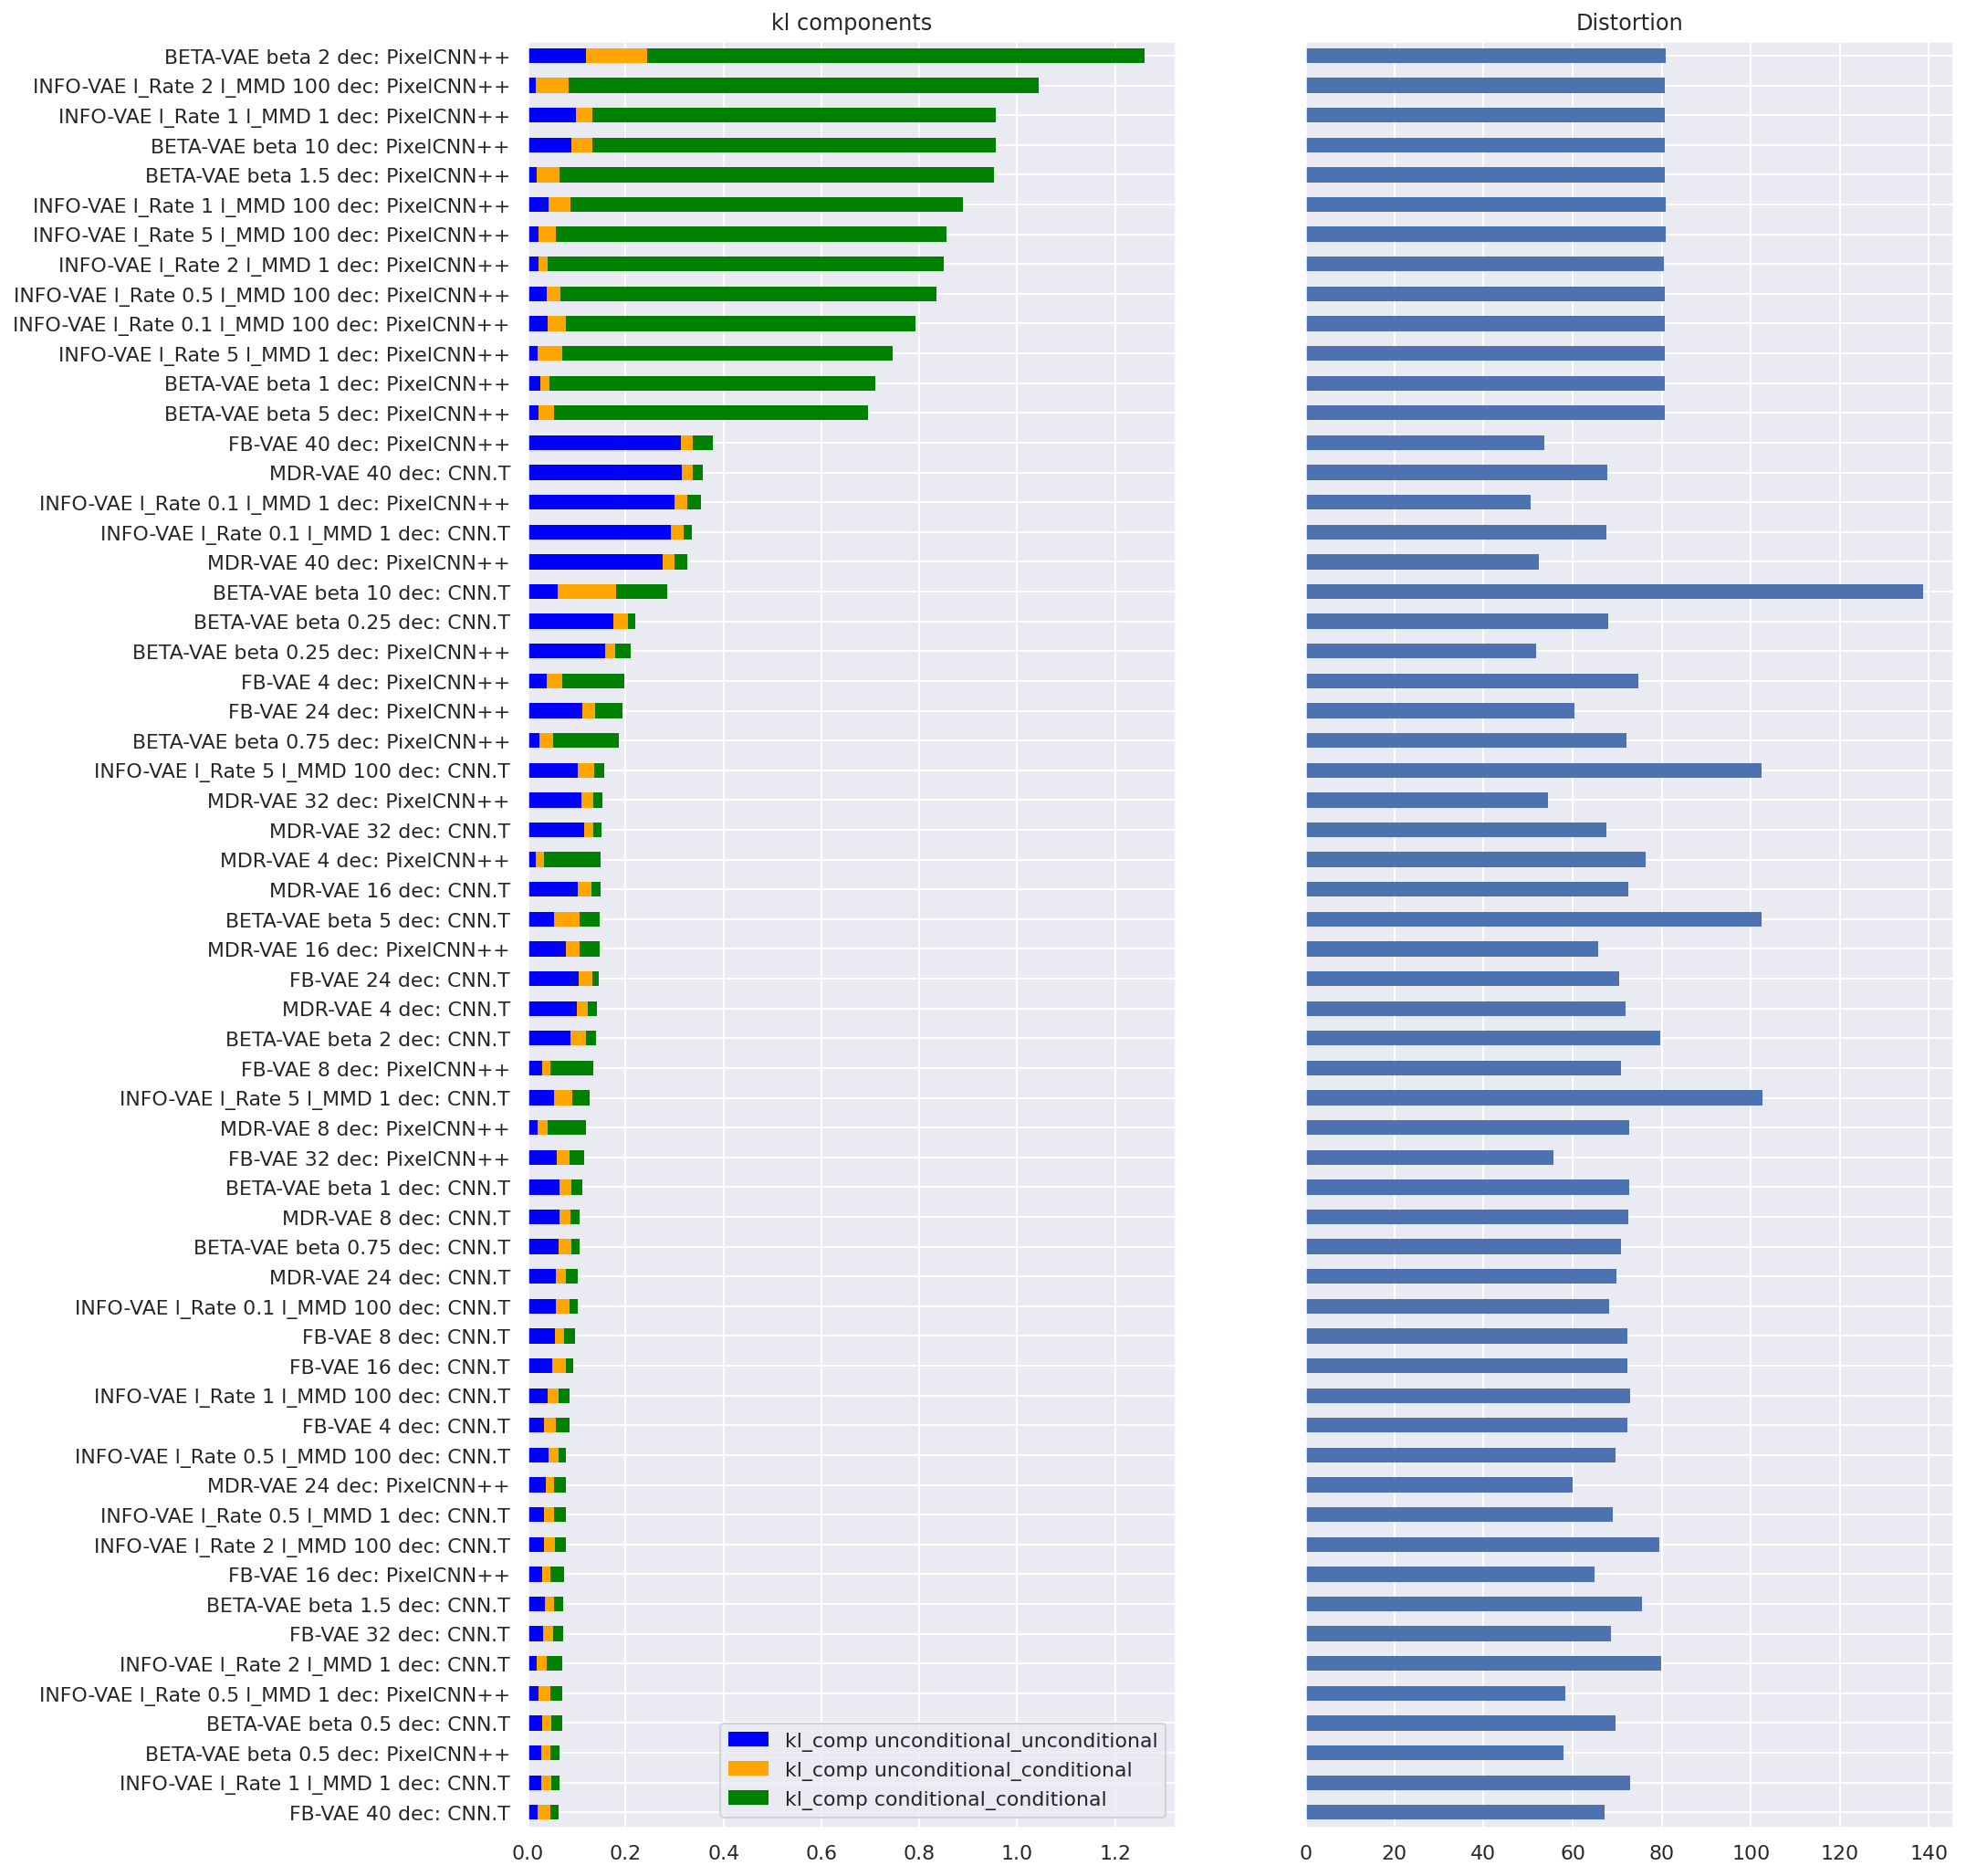

In [74]:
global_stats_df_select["-IW LL"] = - global_stats_df_select["IW LL"]

plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
                                                      plot_against="-IW LL", plot_against_name="-IW LL", 
                                                      stat="kl_comp", figsize=(14, 18))

plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
                                                      plot_against="kl_prior_post", plot_against_name="Rate", 
                                                      stat="kl_comp", figsize=(14, 18))

plot_divergences_data_model_groups_against_other_stat(all_df_select, global_stats_df_select, 
                                                      plot_against="distortion", plot_against_name="Distortion", 
                                                      stat="kl_comp", figsize=(14, 18))

